In [1]:
#Importamos las librerias necesarias 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil

from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statistics import mode
from sklearn.metrics import mean_squared_error

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate=False
logger.setLevel(logging.CRITICAL)

In [2]:
!pip install pmdarima

In [3]:
productos = pd.read_csv(r"C:\Users\adrik\Downloads\product_actualizado.csv")
ventas = pd.read_csv(r"C:\Users\adrik\Downloads\ventas_total.csv")

In [4]:
ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53604 entries, 0 to 53603
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           53604 non-null  int64  
 1   total        53604 non-null  float64
 2   gratuity     53604 non-null  float64
 3   discounts    53604 non-null  float64
 4   taxes        53604 non-null  float64
 5   subtotal     53604 non-null  float64
 6   payed        53604 non-null  float64
 7   table_id     53604 non-null  object 
 8   waiter_id    53604 non-null  int64  
 9   date_open    53604 non-null  object 
 10  date_closed  53604 non-null  object 
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [5]:
ventas.duplicated(subset=['id']).sum()

224

In [6]:
ventas.drop_duplicates(subset=['id'], inplace=True)

In [7]:
productos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172798 entries, 0 to 172797
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      172798 non-null  int64  
 1   product_id    172798 non-null  object 
 2   quantity      172798 non-null  int64  
 3   payed         172798 non-null  float64
 4   taxes         172798 non-null  float64
 5   discounts     172798 non-null  float64
 6   producto      172798 non-null  object 
 7   net_price     172798 non-null  float64
 8   hierarchy_id  172798 non-null  object 
 9   hierarchy     172798 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 13.2+ MB


Observamos que no encontramos valores nulos en ninguna de nuestras dos tablas, los valores duplicados presentan una cantidad no representativa, y se concluyo que al ser repetida la orden, los productos vendidos igualmente estarían represantados en la venta.

In [8]:
df = pd.merge(productos, ventas[['id', 'date_open']], left_on='order_id', right_on='id', how='left')
df.drop('id', axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172798 entries, 0 to 172797
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      172798 non-null  int64  
 1   product_id    172798 non-null  object 
 2   quantity      172798 non-null  int64  
 3   payed         172798 non-null  float64
 4   taxes         172798 non-null  float64
 5   discounts     172798 non-null  float64
 6   producto      172798 non-null  object 
 7   net_price     172798 non-null  float64
 8   hierarchy_id  172798 non-null  object 
 9   hierarchy     172798 non-null  object 
 10  date_open     172798 non-null  object 
dtypes: float64(4), int64(2), object(5)
memory usage: 15.8+ MB


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172798 entries, 0 to 172797
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      172798 non-null  int64  
 1   product_id    172798 non-null  object 
 2   quantity      172798 non-null  int64  
 3   payed         172798 non-null  float64
 4   taxes         172798 non-null  float64
 5   discounts     172798 non-null  float64
 6   producto      172798 non-null  object 
 7   net_price     172798 non-null  float64
 8   hierarchy_id  172798 non-null  object 
 9   hierarchy     172798 non-null  object 
 10  date_open     172798 non-null  object 
dtypes: float64(4), int64(2), object(5)
memory usage: 15.8+ MB


Unimos las tablas de ventas y productos para saber cuantas ventas se hicieron por producto.

In [11]:
df['producto'] = df['producto'].str.replace(r'\s+', ' ', regex=True)
df['producto'] = df['producto'].str.replace(r'\s+', ' ', regex=True).str.strip()
df = df[df['producto'] != 'Aparte']

In [12]:
df = df[['producto', 'date_open']]
df = df.rename(columns={
    'date_open': 'fecha'
})
df = df.sort_values(by='fecha', ascending=True)
df

producto                fecha
117635            Hamburguesa Americana  2021-08-13T19:36:01
56977                   coca cola promo  2021-08-13T21:10:13
56979          pollo albahaca compartir  2021-08-13T21:10:13
56978        coca cola sin azucar promo  2021-08-13T21:10:13
56976   Hamburguesa Hot con papas promo  2021-08-13T21:10:13
...                                 ...                  ...
30331                         Michelada  2024-02-11T04:44:27
30330                    Schop heineken  2024-02-11T04:44:27
149865                       Mistral 35  2024-02-11T04:52:42
149866          Schop kunstman torobayo  2024-02-11T04:52:42
149867                          Chelada  2024-02-11T04:52:42

[171560 rows x 2 columns]

Creamos un dataframe que contenga solo la información que nos interesa, en este caso seria la fecha y nombre del producto (se entiende que cada fila es una venta, estructura que tenia la tabla de ventas original)

In [13]:
df['fecha'] = pd.to_datetime(df['fecha'])
# Establecer la columna 'fecha' como el índice del DataFrame
df.set_index('fecha', inplace=True)
# Agrupar los datos por producto y semana, y contar las ventas para cada grupo
ventas_semanales = df.groupby(['producto', pd.Grouper(freq='W')]).size().reset_index(name='ventas_semanales')
# Ver las primeras filas del DataFrame resultante para verificar la agrupación y el conteo
ventas_semanales

producto      fecha  ventas_semanales
0              2 Black label 2023-01-22                 8
1                  2 Cacique 2023-02-19                 1
2                  2 Cacique 2023-03-05                 1
3                  2 Cacique 2023-08-06                 3
4      2 Cosmopolitan x 7990 2022-04-03                 4
...                      ...        ...               ...
17004      veggie individual 2024-01-14                 2
17005      veggie individual 2024-01-21                12
17006      veggie individual 2024-01-28                 7
17007      veggie individual 2024-02-04                 8
17008      veggie individual 2024-02-11                 6

[17009 rows x 3 columns]

Trasnformamos el tipo de datos de fecha al tipo correcto, datetime en este caso para poder hacer análisis de series temporales.
Se ha agrupado por producto y por semana para saber cuantas cantidades se venden por producto semanalmente. Esta periocidad se escogió porque nuestra predicción debe ser semanal.

In [14]:
# Identificar los productos que tienen al menos 104 registros semanales (2 años de datos semanales)
productos = ventas_semanales.groupby('producto').filter(lambda x: len(x) >= 104)['producto'].unique()
# Filtrar los datos para quedarnos solo con esos productos
df = ventas_semanales[ventas_semanales['producto'].isin(productos)]
df

producto      fecha  ventas_semanales
328     2 SCHOP HEINEKEN 2021-12-12                 2
329     2 SCHOP HEINEKEN 2021-12-19                24
330     2 SCHOP HEINEKEN 2021-12-26                 2
331     2 SCHOP HEINEKEN 2022-01-02                47
332     2 SCHOP HEINEKEN 2022-01-09                25
...                  ...        ...               ...
17004  veggie individual 2024-01-14                 2
17005  veggie individual 2024-01-21                12
17006  veggie individual 2024-01-28                 7
17007  veggie individual 2024-02-04                 8
17008  veggie individual 2024-02-11                 6

[9231 rows x 3 columns]

Hicimos una limpieza de productos que no se vendieron en todo el periodo comprendido, hay productos que solo aparecian al principio de nuestra serie de tiempo y otros solo al final, al trabajar con series de tiempo la integridad de los datos de fecha son muy importante y representativos. Decidimos solo analizar productos que se han mantenido a lo largo del tiempo estudiado.

In [15]:
# Suponiendo que tu DataFrame se llama df
# Asegúrate de que tu DataFrame esté cargado correctamente aquí.
# Calcular el promedio de ventas semanales por producto
promedio_por_producto = df.groupby('producto')['ventas_semanales'].mean()
# Por ejemplo, establecer el umbral como el 25% percentil de los promedios de ventas
umbral = promedio_por_producto.quantile(0.5)
# Filtrar para obtener los productos con un promedio de ventas por debajo del umbral
productos_bajo_rendimiento = promedio_por_producto[promedio_por_producto < umbral].index.tolist()
# Mostrar los productos que se consideran de bajo rendimiento
productos_bajo_rendimiento

['Aperol Spritz',
 'Bacon',
 'Caipiriña',
 'Calypso',
 'Crema acida',
 'Guacamole',
 'Hamburguesa Americana con papas promo',
 'Hamburguesa Vegana',
 'Hamburguesa Vegetariana con papas promo',
 'Honey Mustard',
 'Jugo de frambuesa',
 'Jugo de mango',
 'Jugo de maracuya',
 'Lemon Garlic',
 'Limonada Menta Jengibre',
 'Limonada menta',
 'Margarita',
 'Moscow Mule',
 'Pebre',
 'Pisco Sour',
 'Salsa de la casa',
 'Salsa picante',
 'Tom Collins',
 'Vegetales salteados',
 'beefie compartir promo',
 'chicken curry compartir',
 'chicken curry individual',
 'choclo champiñon compartir promo',
 'fanta',
 'jugo durazno promo',
 'mechada compartir promo',
 'mexa individual',
 'pollo albahaca individual',
 'single fries individual',
 'sprite',
 'sprite promo',
 'veggie compartir promo',
 'veggie individual']

Observamos tambien productos con ventas muy bajas, con stock minimo puede abastecerse el local para su salida. Decidimos enfocarnos en los productos con mayor cantidad de ventas. Para esto de estableció un umbral promedio de número de ventas que debia cumplir el producto para que su estudio fuera tomado en cuenta.

In [16]:
df= df[~df['producto'].isin(productos_bajo_rendimiento)]

In [17]:
df['producto'].nunique()

38

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4785 entries, 328 to 16758
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   producto          4785 non-null   object        
 1   fecha             4785 non-null   datetime64[ns]
 2   ventas_semanales  4785 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 149.5+ KB


Utilizaremos un headmap para poder observar la frecuencia de venta y en que periodo se presenta esta frecuencia por producto. 
Trabajamos con varios producto, asi que se decidió separar por grupos representativos para una mejor visualización de los datos.
Crearemos dos grupos: Comida y tragos.

In [19]:
# Palabras clave para identificar los productos de comida
palabras_clave_comida = ['papas', 'individual', 'compartir', 'Hamburguesa', 'Chicken', 'Cheddar', 'Crema acida', 'Salsa','Vegetales salteados']
# Crear la cadena de consulta para comida
consulta_comida = " | ".join([f"producto.str.contains('{palabra}', case=False, na=False)" for palabra in palabras_clave_comida])
# Filtrar el DataFrame para obtener solo los productos de comida
df_comida = df.query(consulta_comida)
# Filtrar el DataFrame para obtener los productos que no son comida (tragos)
df_tragos = df.query(f"not ({consulta_comida})")

In [20]:
# Asegúrate de que df_comida y df_tragos son copias independientes para evitar la advertencia
df_comida = df_comida.copy()
df_tragos = df_tragos.copy()

# Asignar valores a la nueva columna 'semana_del_año' correctamente
df_comida['semana_del_año'] = df['fecha'].dt.isocalendar().week
df_tragos['semana_del_año'] = df['fecha'].dt.isocalendar().week

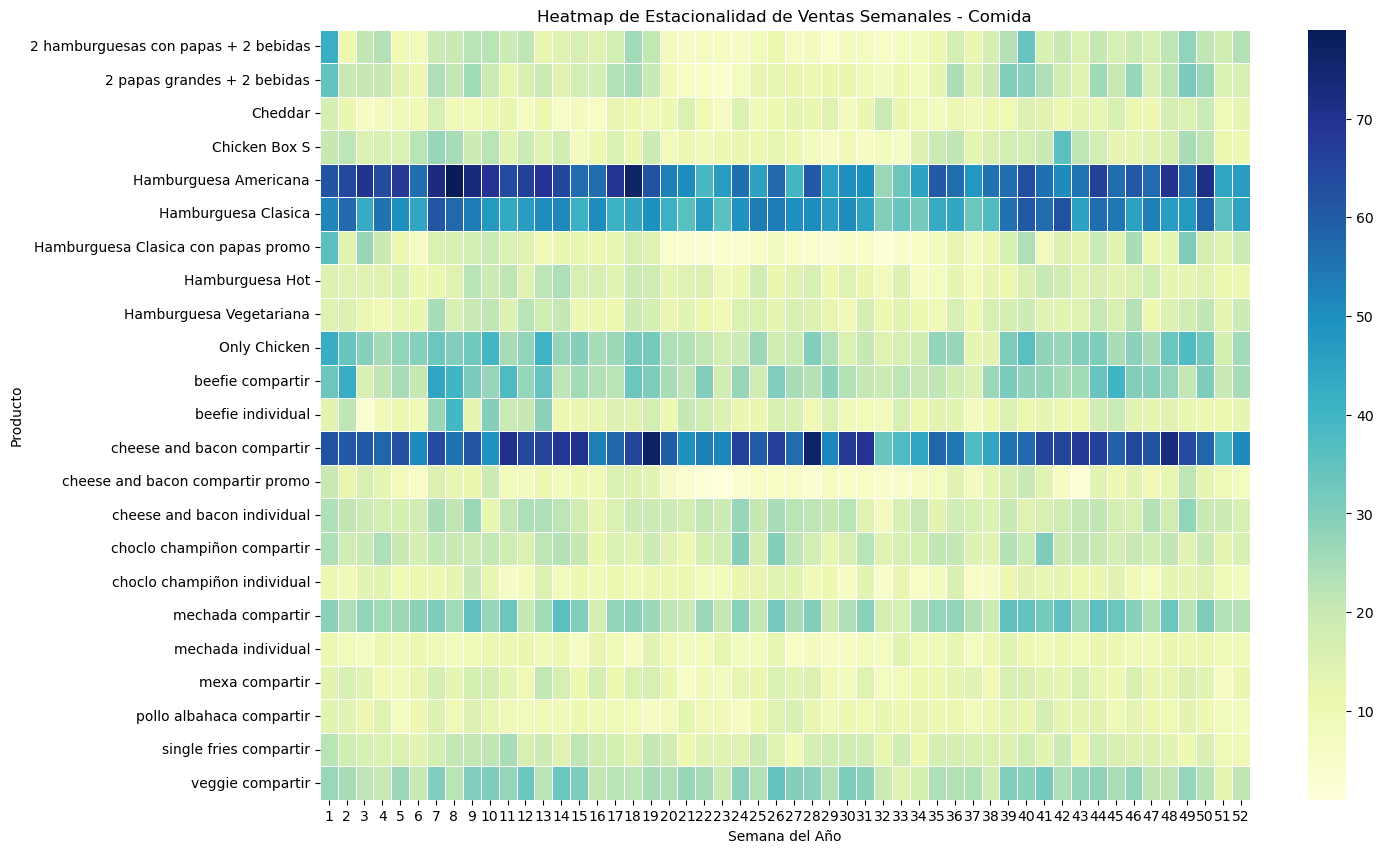

In [21]:
heatmap_data_comida = df_comida.groupby(['producto', 'semana_del_año']).ventas_semanales.mean().unstack()
# Crear el heatmap para comida
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_comida, cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap de Estacionalidad de Ventas Semanales - Comida')
plt.ylabel('Producto')
plt.xlabel('Semana del Año')
plt.show()

Observamos en nuestro headmap de comida por semana del año, y podemos identificar los productos con mayores ventas como:
- Hamburguesa Americana 
- Hamburguesa Clásica
- Cheese and bacon para compartir
- Only chicken
- Beefie para compartir
- Mechada para compartir 
- Veggie para compartir 

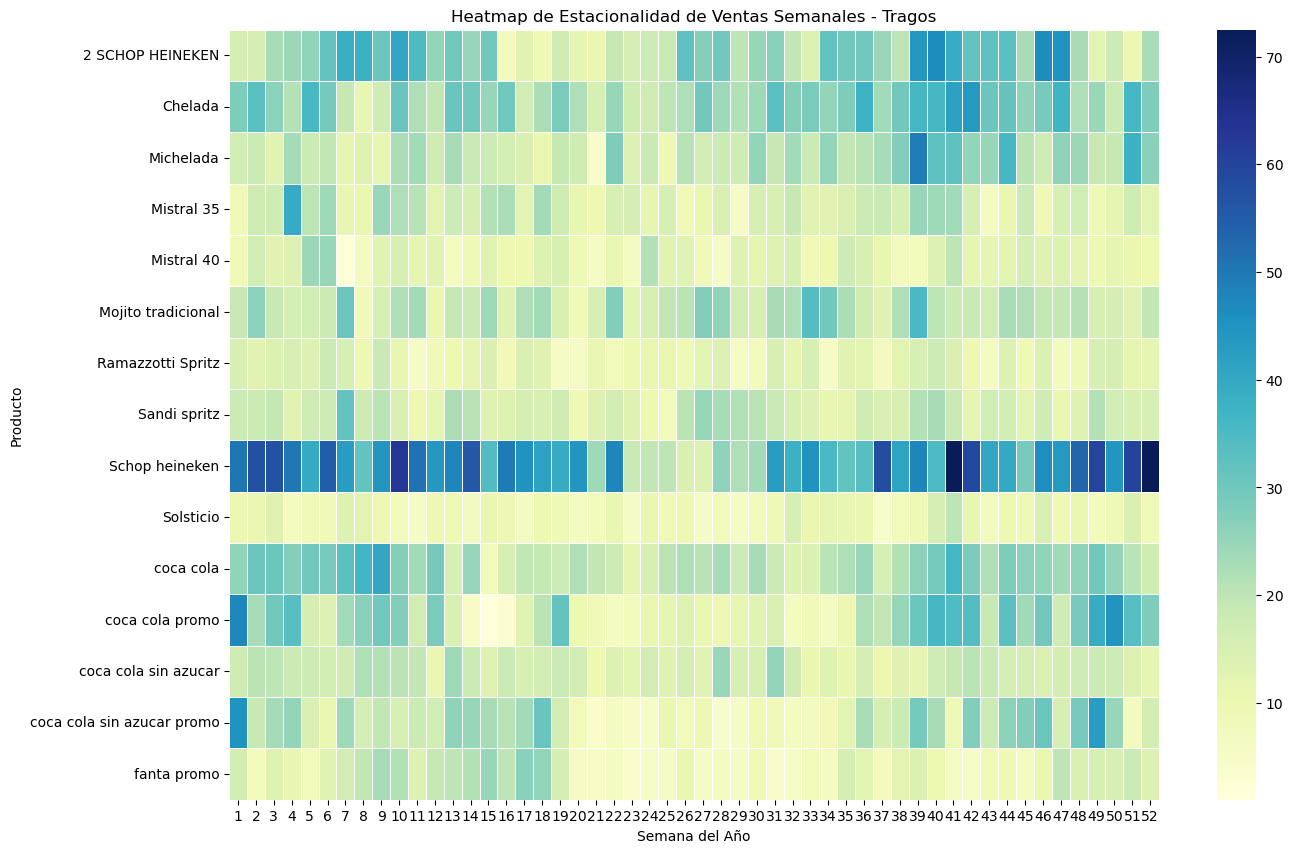

In [22]:
heatmap_data_tragos = df_tragos.groupby(['producto', 'semana_del_año']).ventas_semanales.mean().unstack()
# Crear el heatmap para tragos
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_tragos, cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap de Estacionalidad de Ventas Semanales - Tragos')
plt.ylabel('Producto')
plt.xlabel('Semana del Año')
plt.show()

Observamos en nuestro headmap de tragos por semana del año, y podemos identificar los productos con mayores ventas como:
- Schop de heineken 
- 2 Schop de hieneken
- Chelada
- Michelada
- Mojito tradicional 
- Coca cola  
- Coca cola zero 

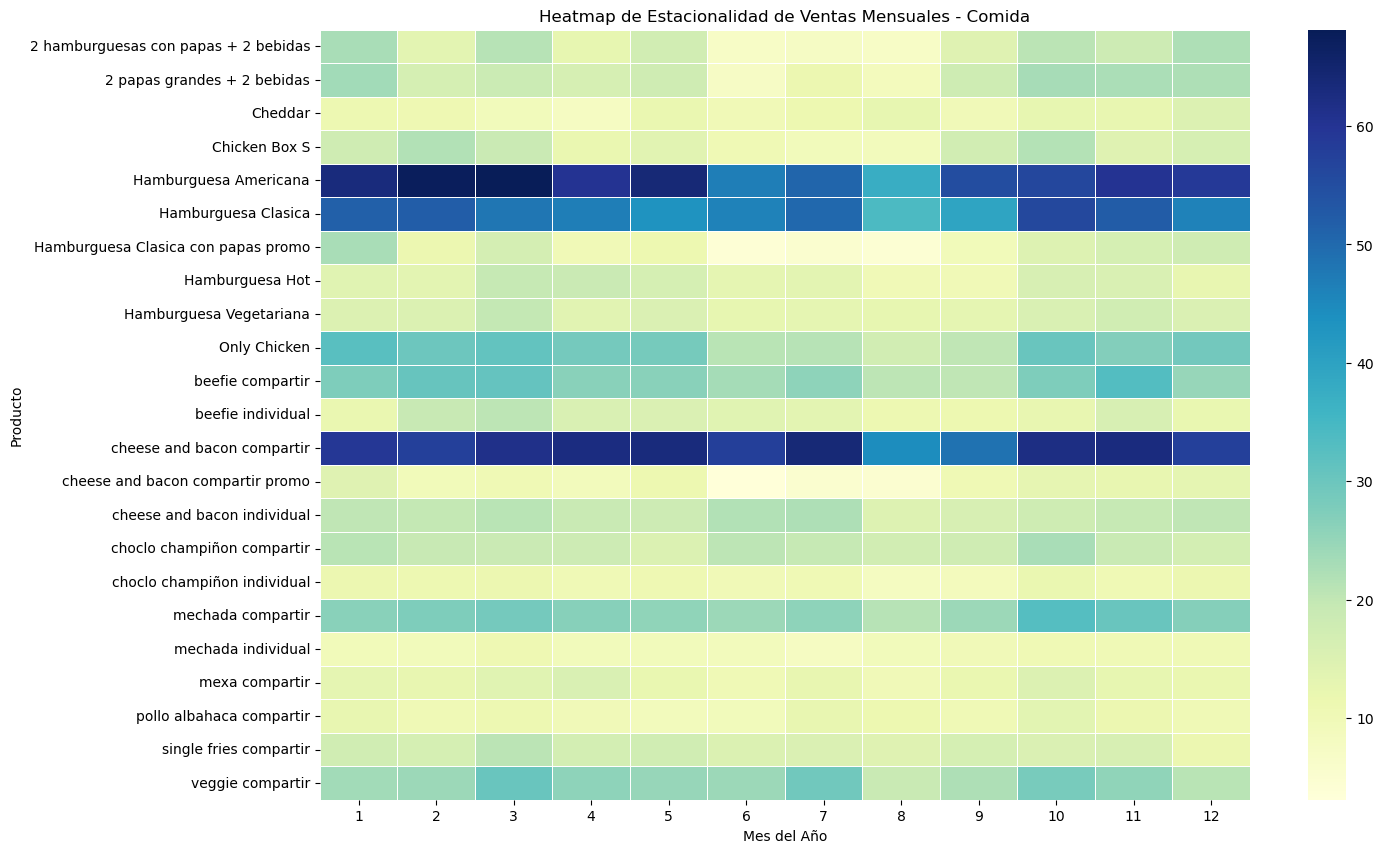

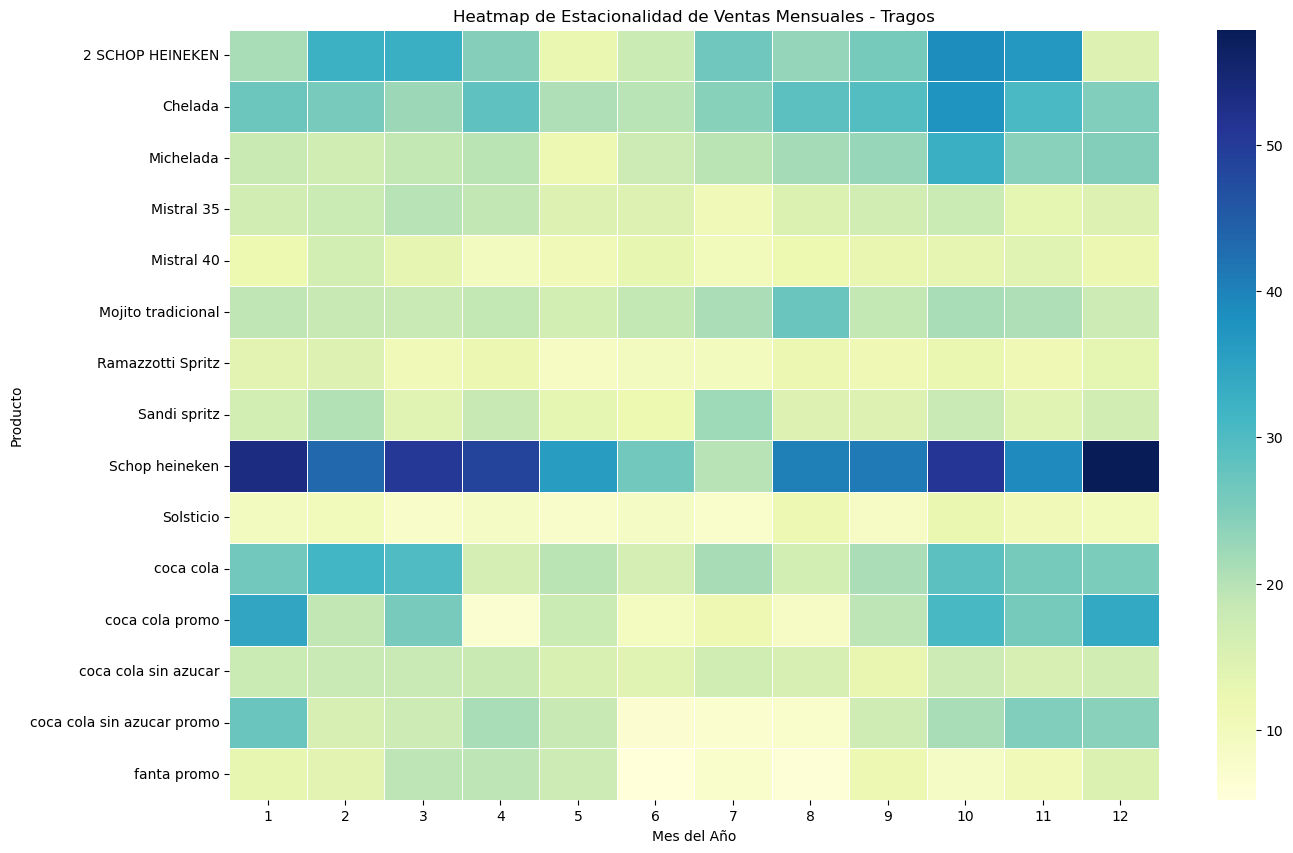

In [23]:
# Agregar la columna 'mes_del_año' a cada DataFrame
df_comida['mes_del_año'] = df_comida['fecha'].dt.month
df_tragos['mes_del_año'] = df_tragos['fecha'].dt.month
# Preparar los datos para los heatmaps mensuales
heatmap_data_comida_mensual = df_comida.groupby(['producto', 'mes_del_año']).ventas_semanales.mean().unstack()
heatmap_data_tragos_mensual = df_tragos.groupby(['producto', 'mes_del_año']).ventas_semanales.mean().unstack()

# Crear los heatmaps mensuales
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_comida_mensual, cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap de Estacionalidad de Ventas Mensuales - Comida')
plt.ylabel('Producto')
plt.xlabel('Mes del Año')

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_tragos_mensual, cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap de Estacionalidad de Ventas Mensuales - Tragos')
plt.ylabel('Producto')
plt.xlabel('Mes del Año')
plt.show()


En nuestros heatmaps mensuales podemos observar levemente la tendencia de que los meses que presentan una mayor frecuencia entres los meses:
- Octubre
- Noviembre
- Diciembre
- Enero 
- Febrero
- Marzo

In [24]:
# Establecer la columna 'fecha' como el índice del dataframe
df.set_index('fecha', inplace=True)

# Reorganizar el dataframe para tener las ventas semanales como columnas separadas
df_pivot = df.pivot_table(index='fecha', columns='producto', values='ventas_semanales', fill_value=0)
# Si hay fechas faltantes, puedes rellenarlas con 0
df_pivot = df_pivot.resample('W').sum().fillna(0)


# Ahora df_pivot está listo para ser utilizado en un modelo ARIMA
df_pivot

producto    2 SCHOP HEINEKEN  2 hamburguesas con papas + 2 bebidas  \
fecha                                                                
2021-08-15                 0                                     4   
2021-08-22                 0                                     0   
2021-08-29                 0                                    11   
2021-09-05                 0                                    20   
2021-09-12                 0                                    34   
...                      ...                                   ...   
2024-01-14                19                                     1   
2024-01-21                 5                                     1   
2024-01-28                 8                                     2   
2024-02-04                20                                     2   
2024-02-11                24                                     1   

producto    2 papas grandes + 2 bebidas  Cheddar  Chelada  Chicken Box S  \
fecha                                                                      
2021-08-15                            3        0        0              1   
2021-08-22                            6        0        0              3   
2021-08-29                            7        4        0             23   
2021-09-05                           24       12        0             40   
2021-09-12                           49       18        0             48   
...                                 ...      ...      ...            ...   
2024-01-14                            5        8       46              0   
2024-01-21                            3        2       36              0   
2024-01-28                            2       12       34              0   
2024-02-04                            8        9       47              1   
2024-02-11                            6        5       50              0   

producto    Hamburguesa Americana  Hamburguesa Clasica  \
fecha                                                    
2021-08-15                      5                    5   
2021-08-22                      4                    2   
2021-08-29                     38                   23   
2021-09-05                     59                   26   
2021-09-12                     59                   50   
...                           ...                  ...   
2024-01-14                     46                   35   
2024-01-21                     42                   26   
2024-01-28                     42                   43   
2024-02-04                     44                   35   
2024-02-11                     40                   28   

producto    Hamburguesa Clasica con papas promo  Hamburguesa Hot  ...  \
fecha                                                             ...   
2021-08-15                                    1                0  ...   
2021-08-22                                    0                0  ...   
2021-08-29                                    8                1  ...   
2021-09-05                                   15                6  ...   
2021-09-12                                   25               11  ...   
...                                         ...              ...  ...   
2024-01-14                                    0                5  ...   
2024-01-21                                    0                8  ...   
2024-01-28                                    1               13  ...   
2024-02-04                                    1                7  ...   
2024-02-11                                    1                8  ...   

producto    coca cola promo  coca cola sin azucar  coca cola sin azucar promo  \
fecha                                                                           
2021-08-15                4                     0                           4   
2021-08-22                4                     3                           3   
2021-08-29                5                     5                      

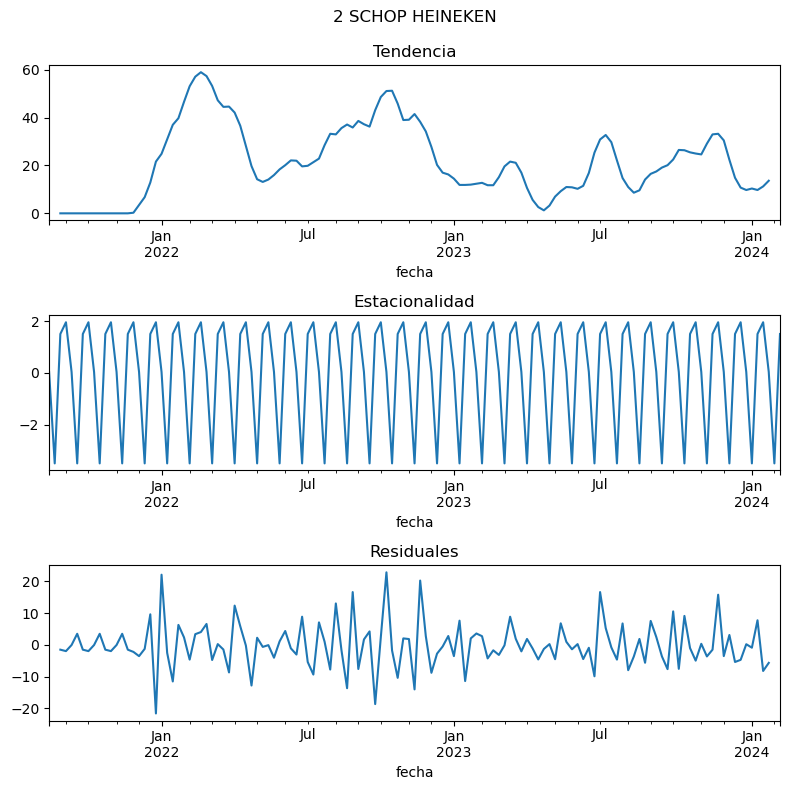

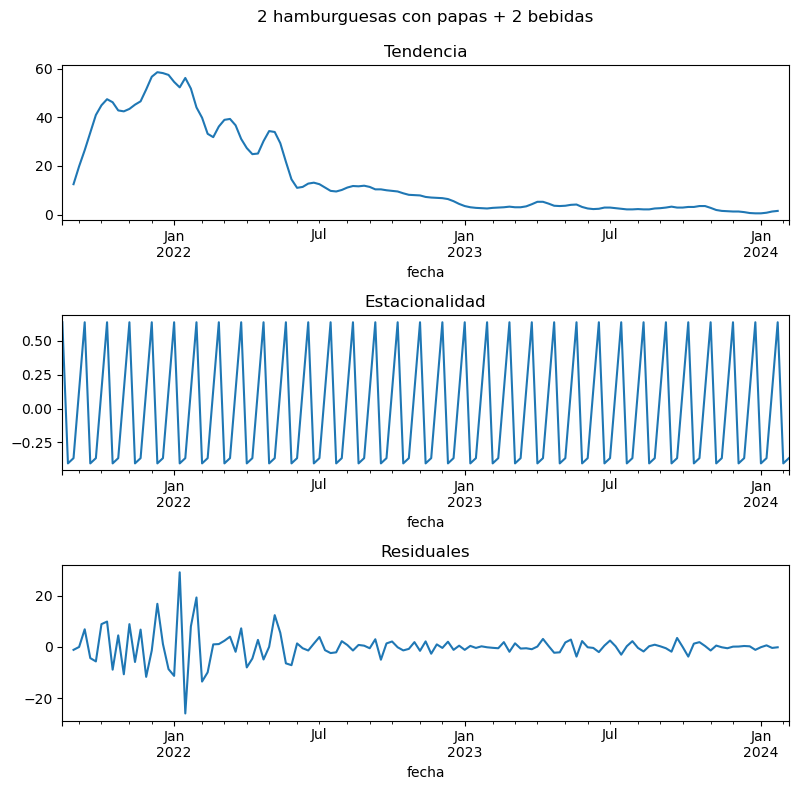

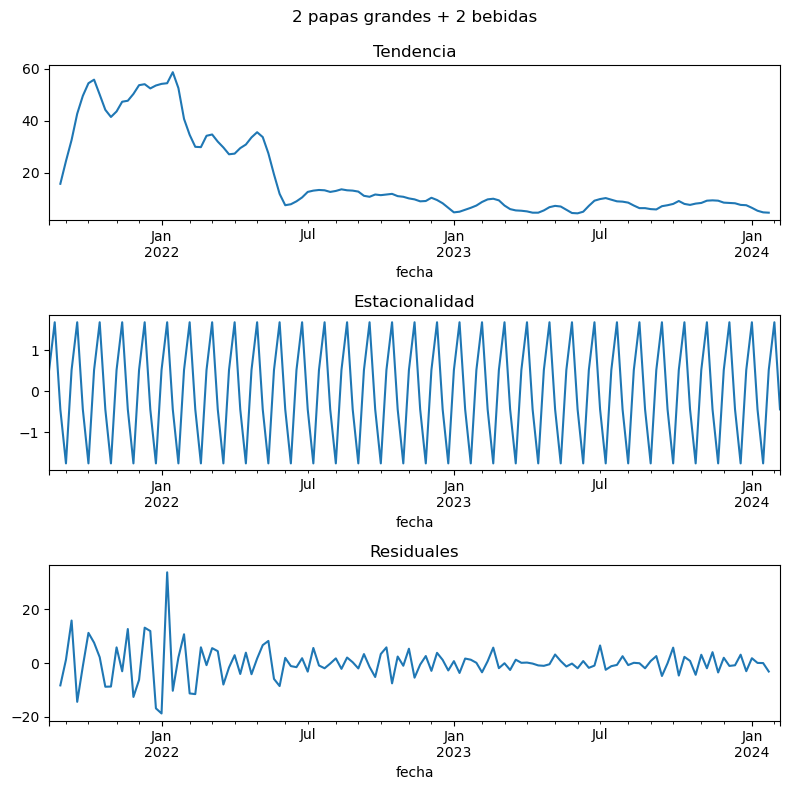

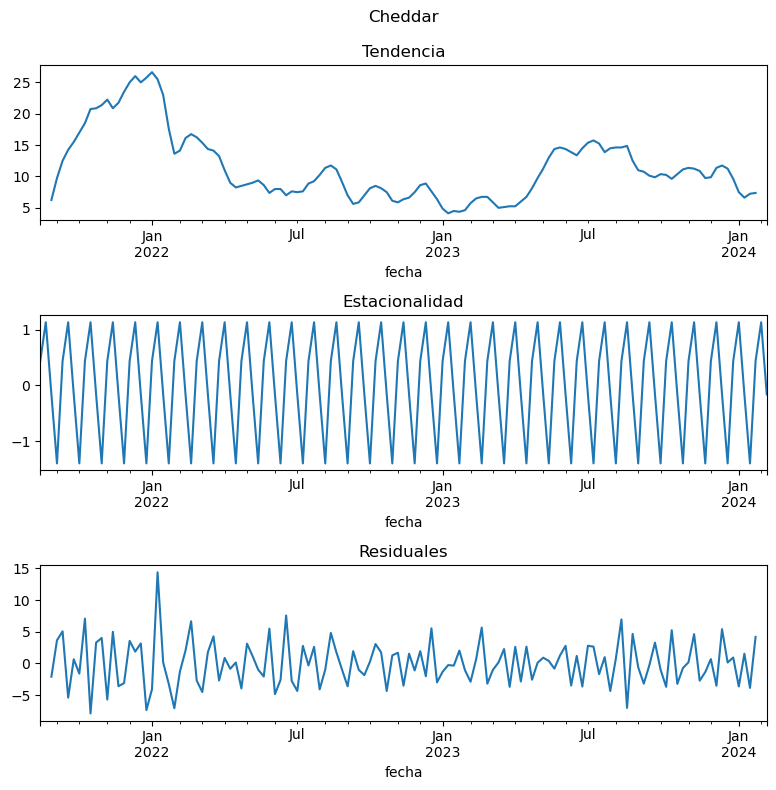

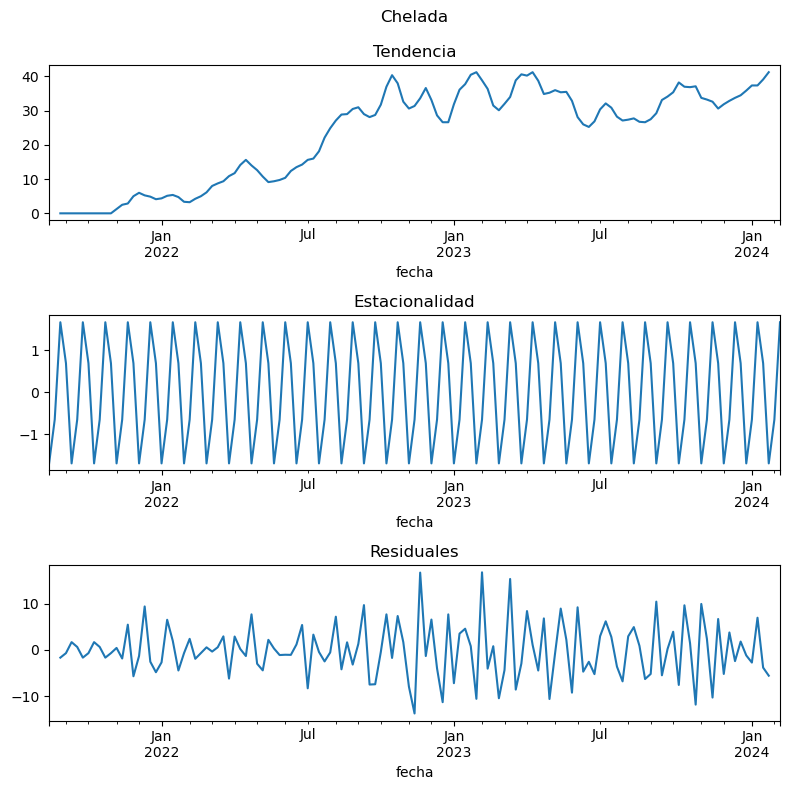

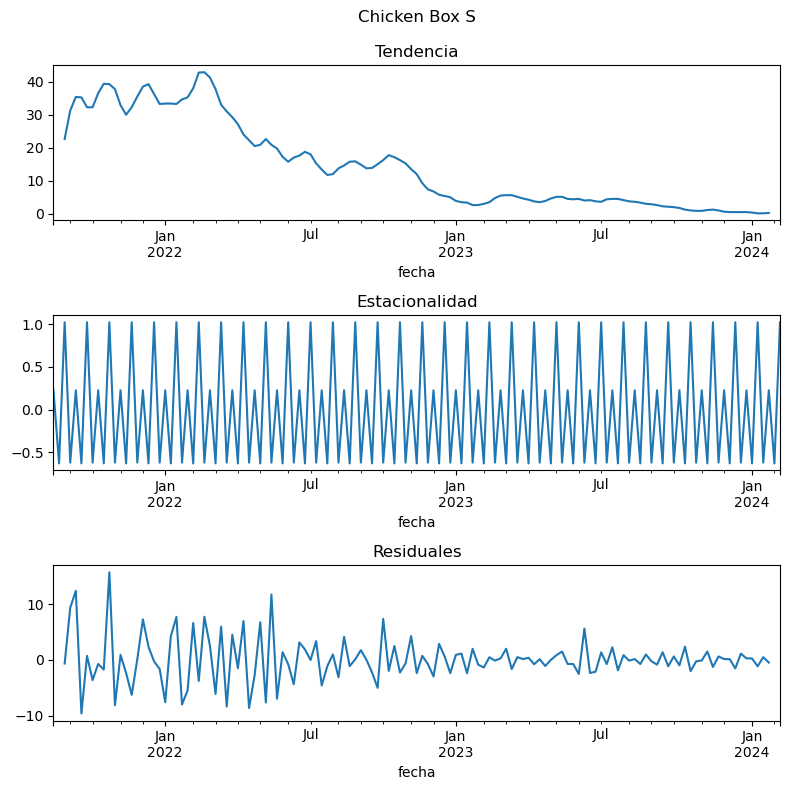

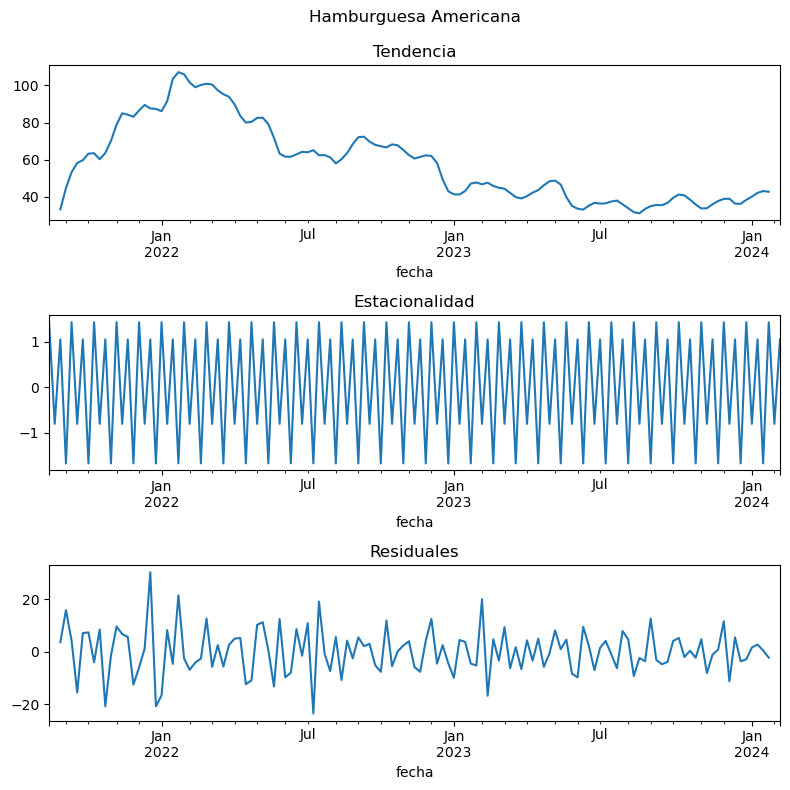

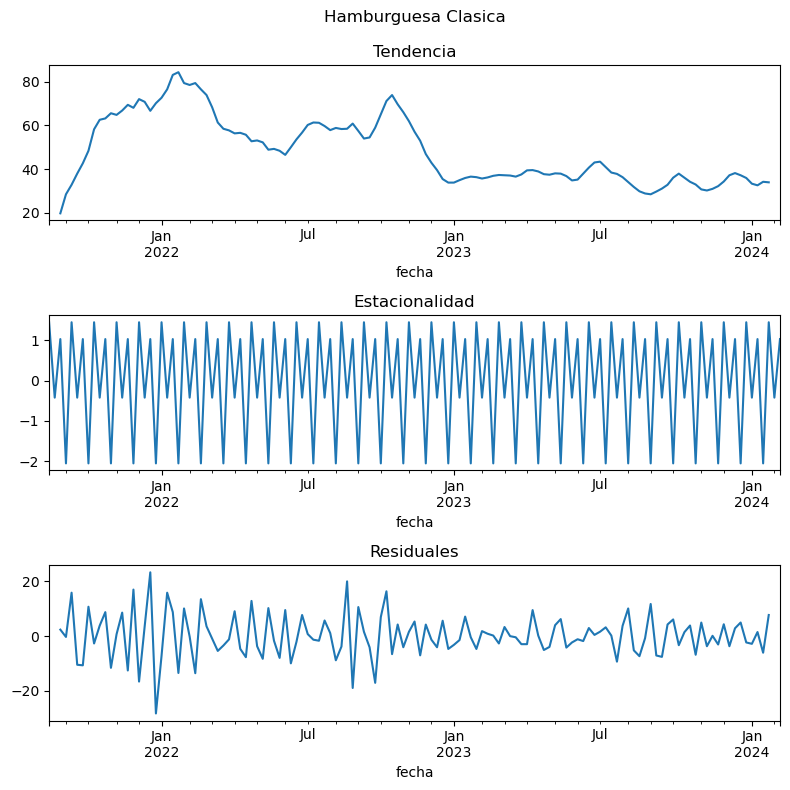

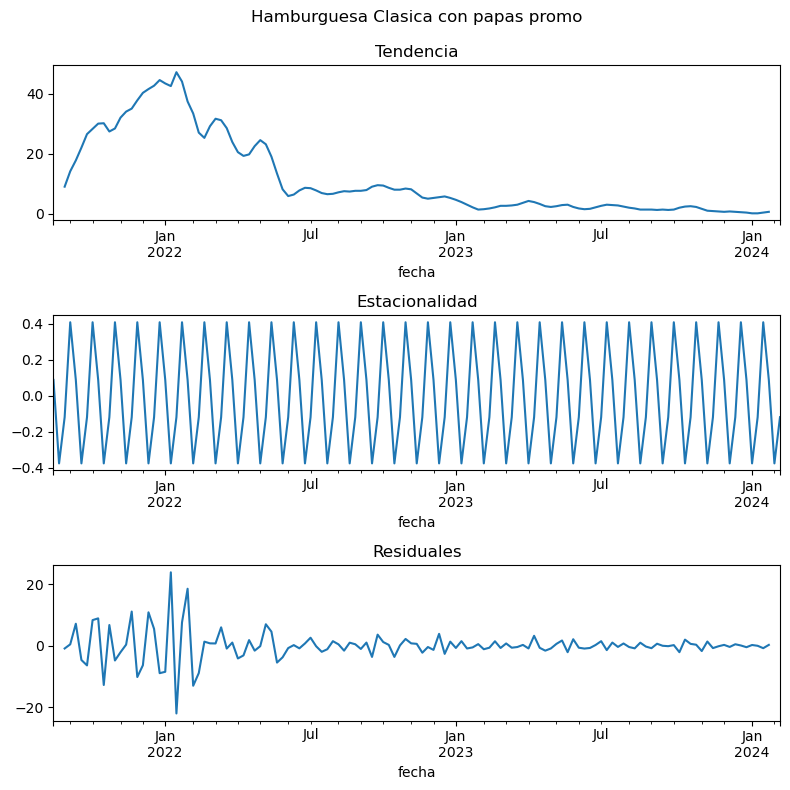

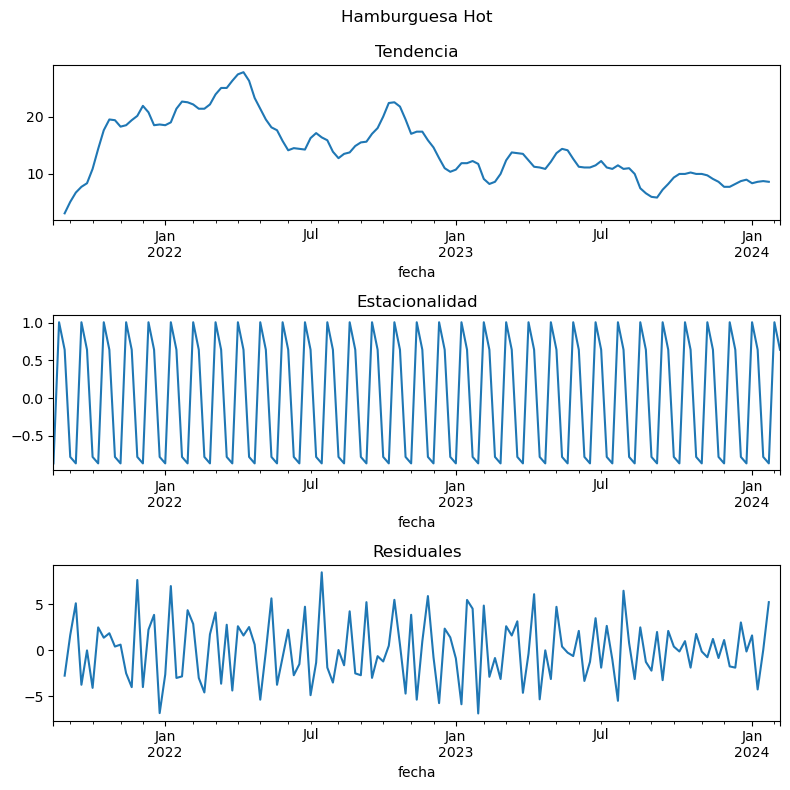

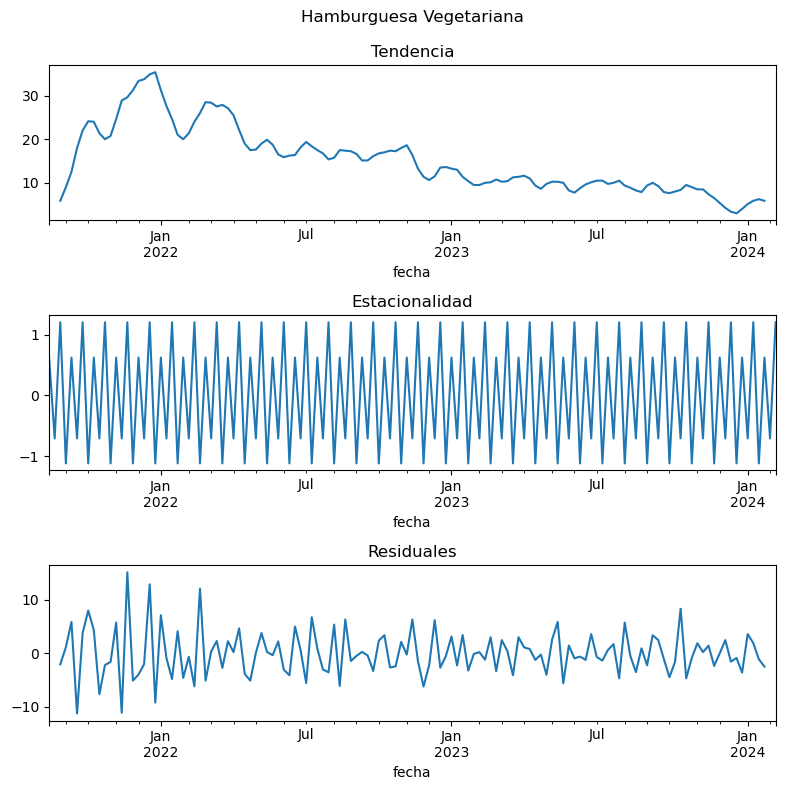

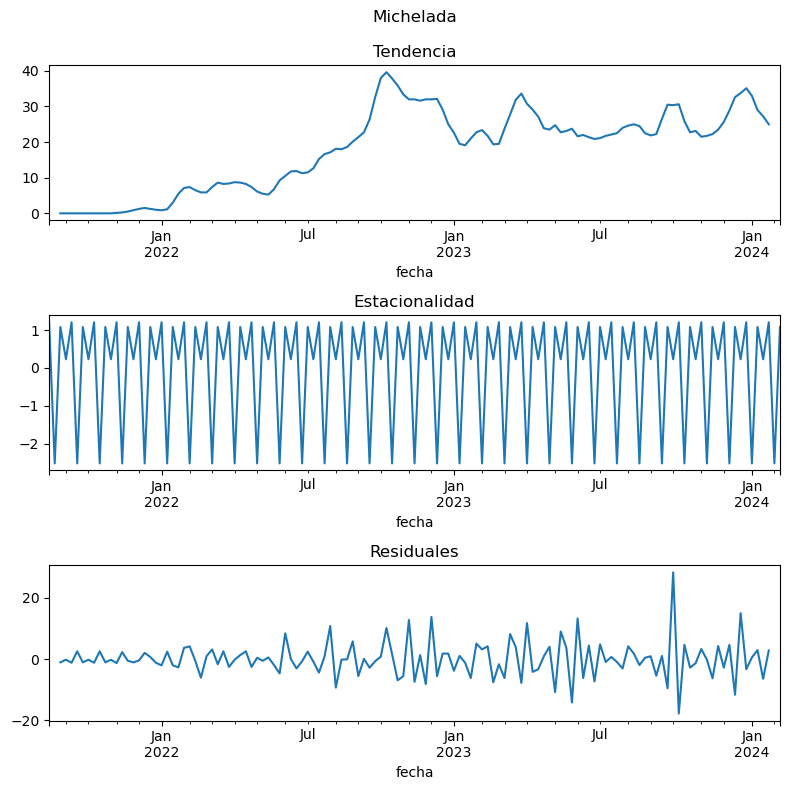

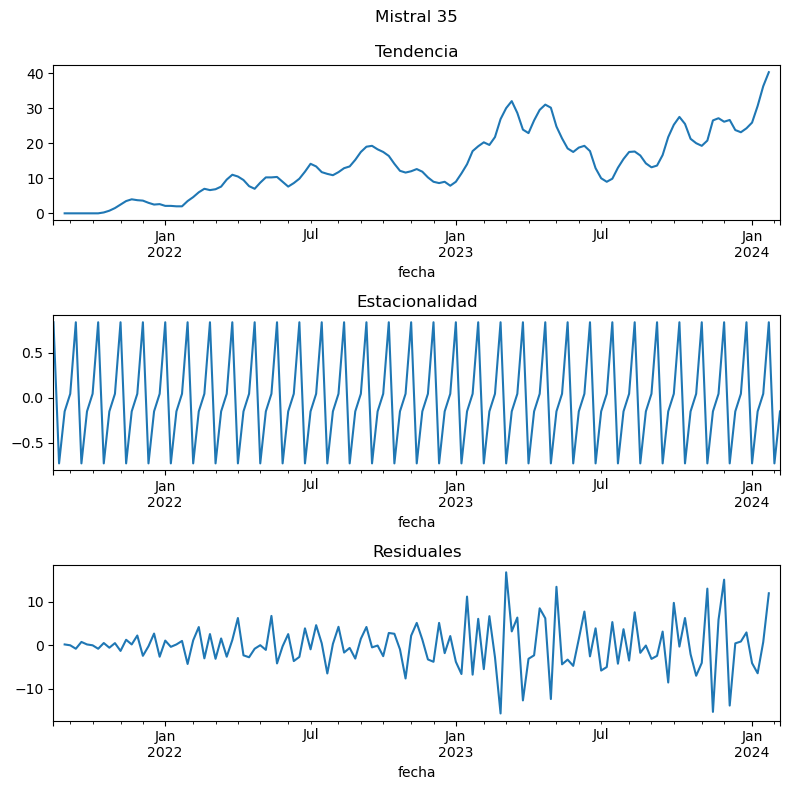

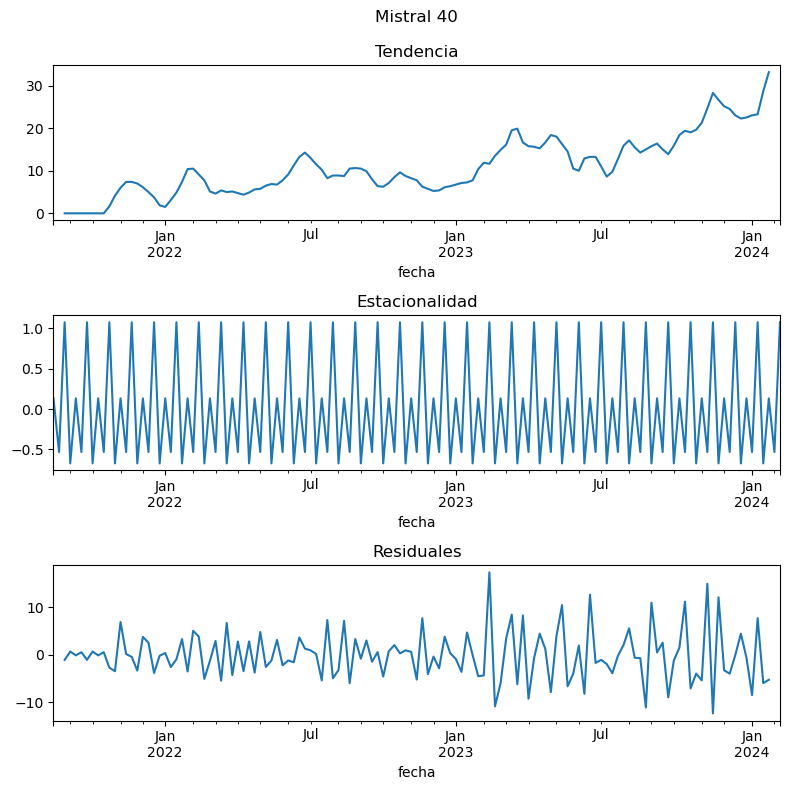

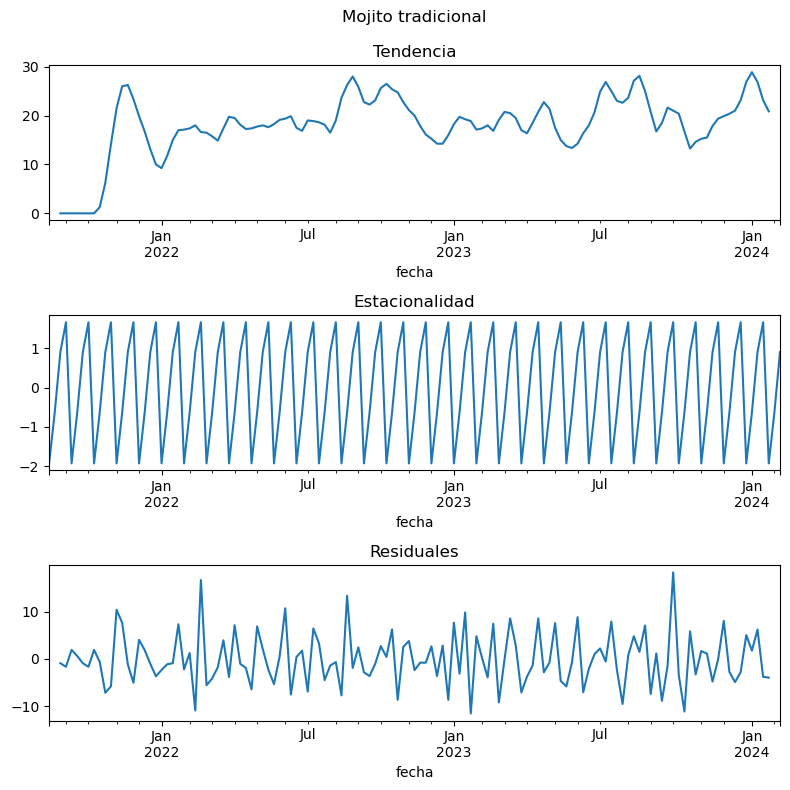

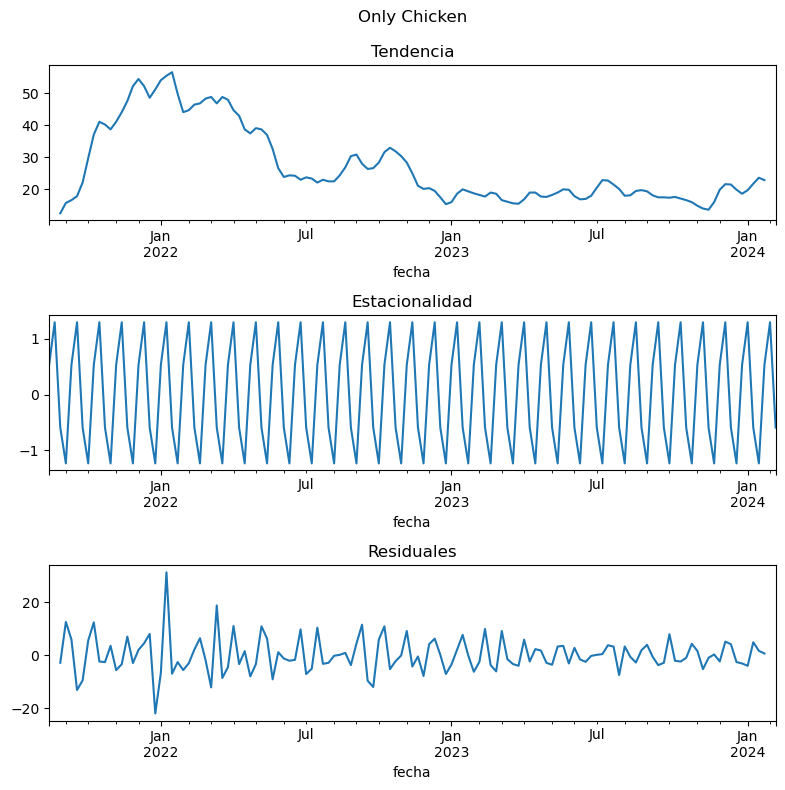

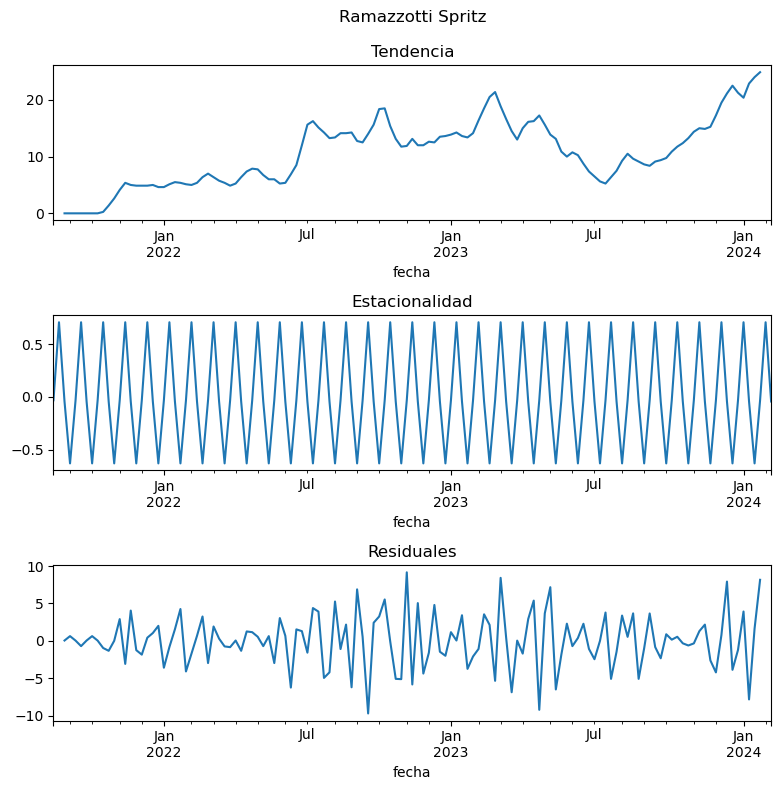

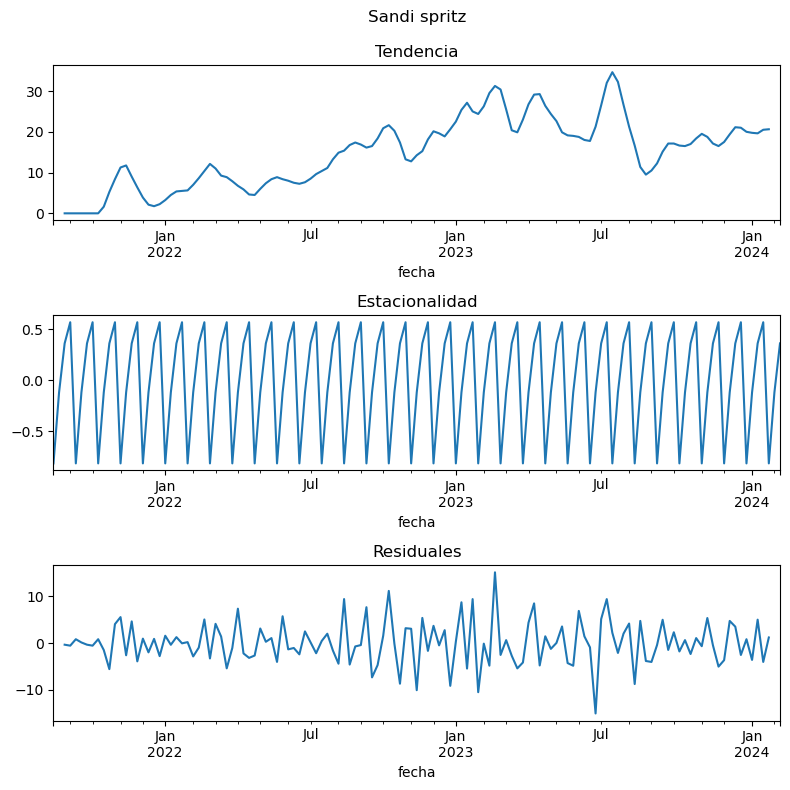

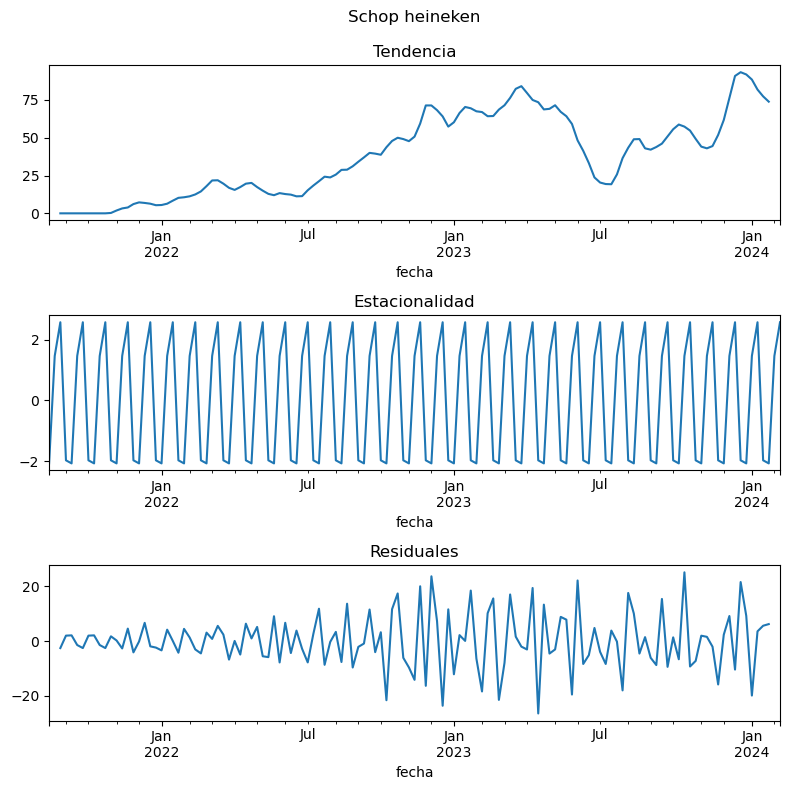

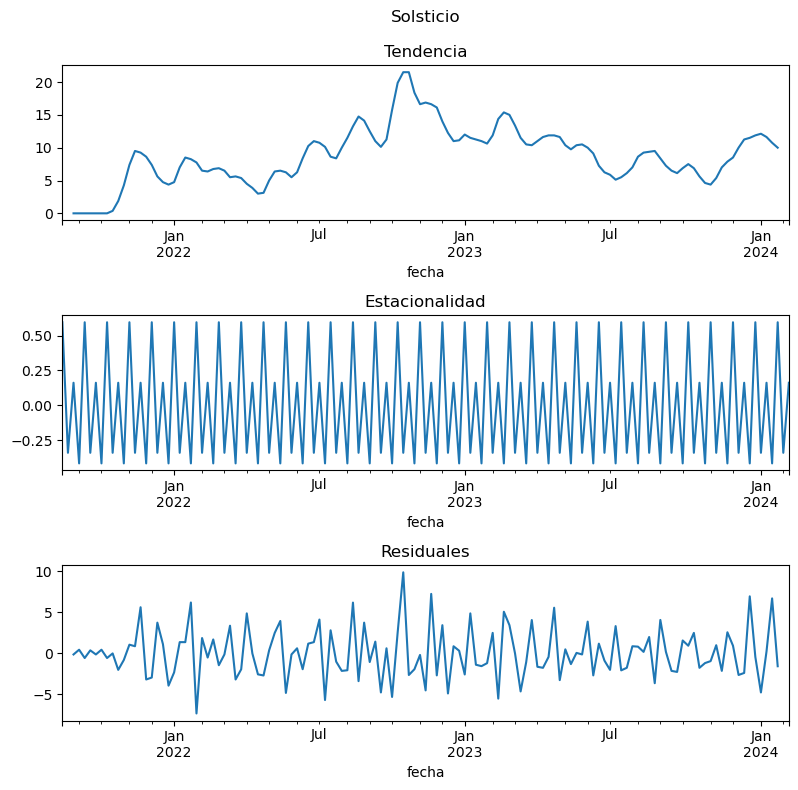

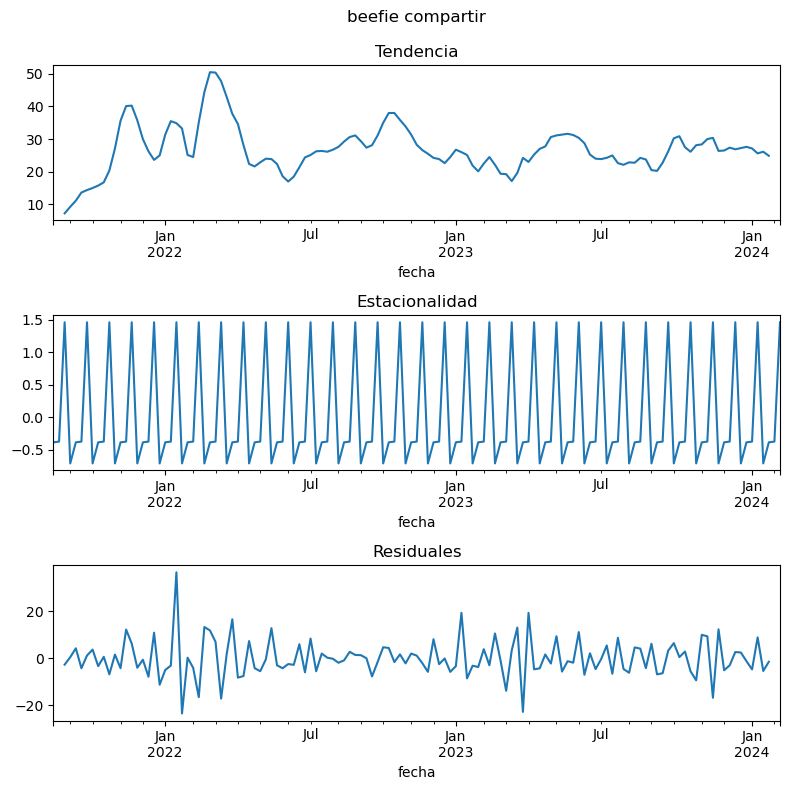

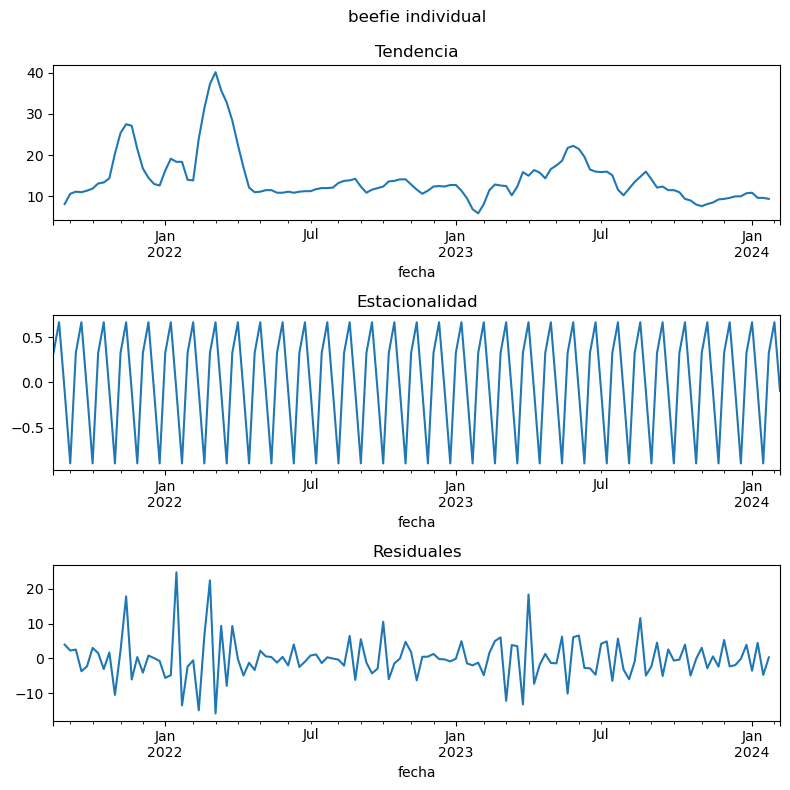

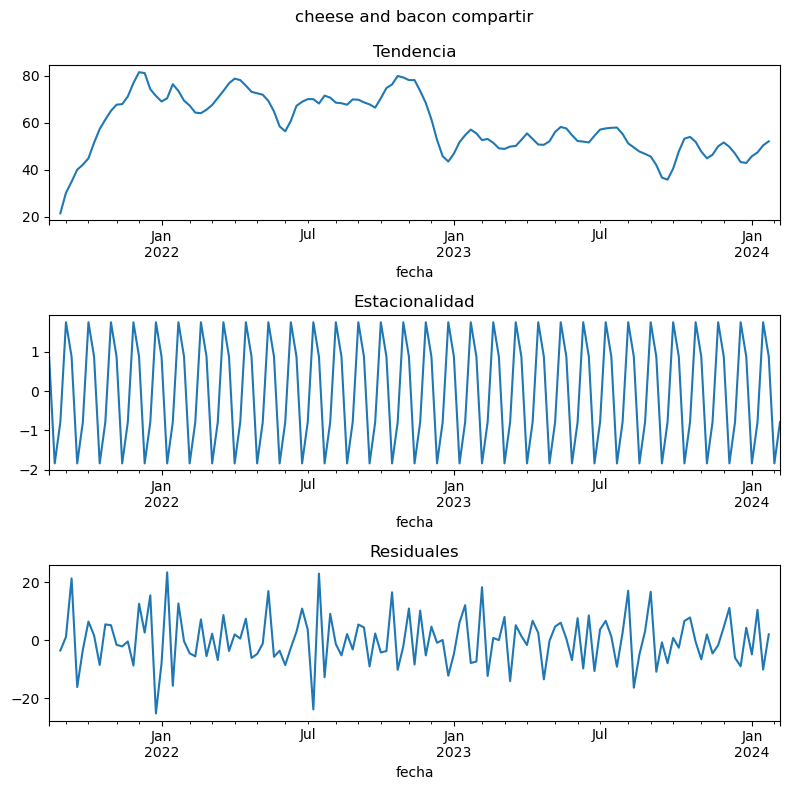

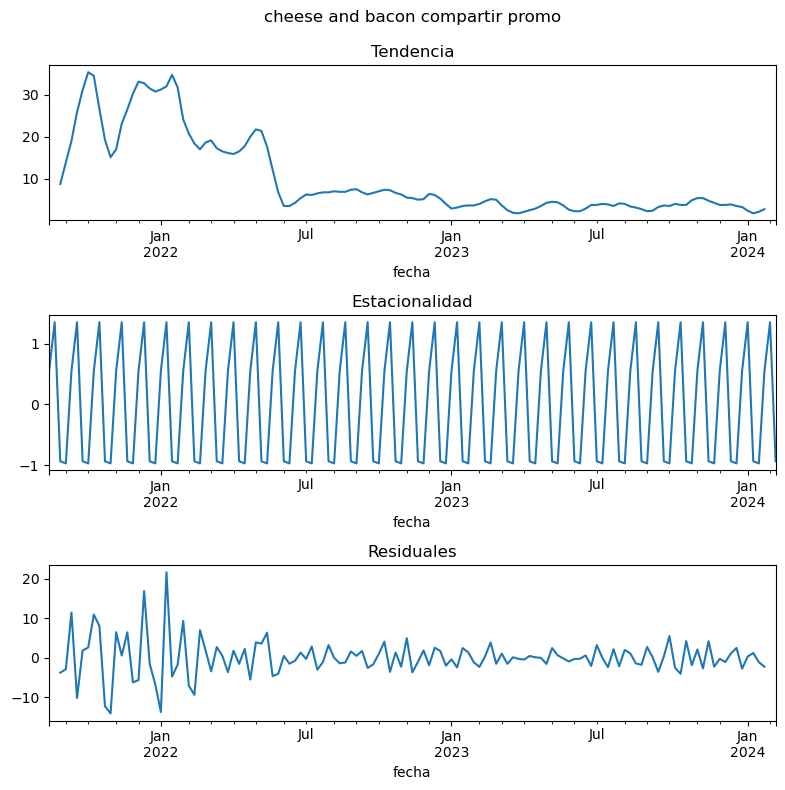

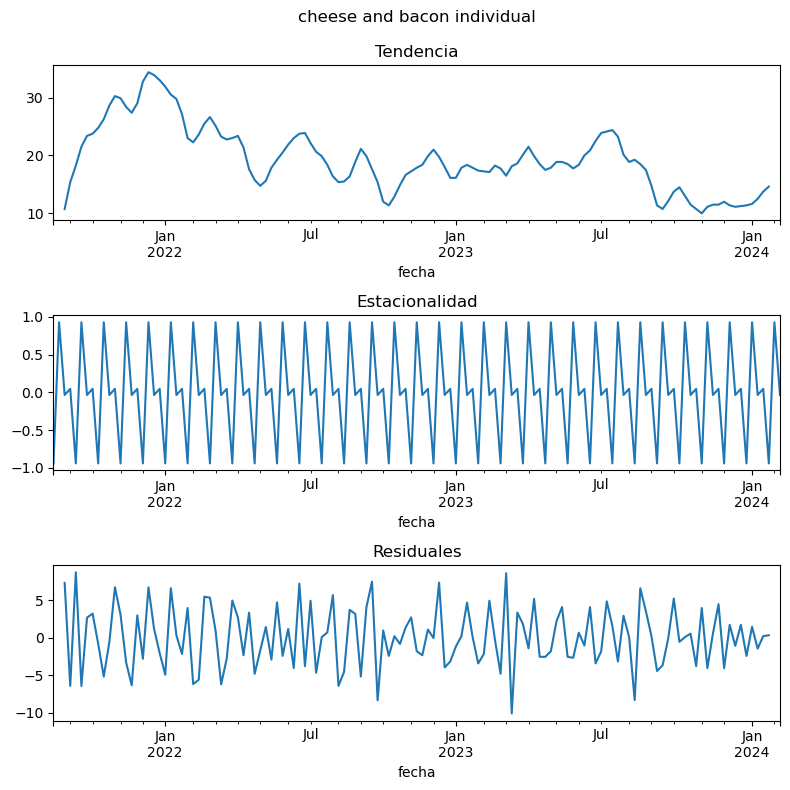

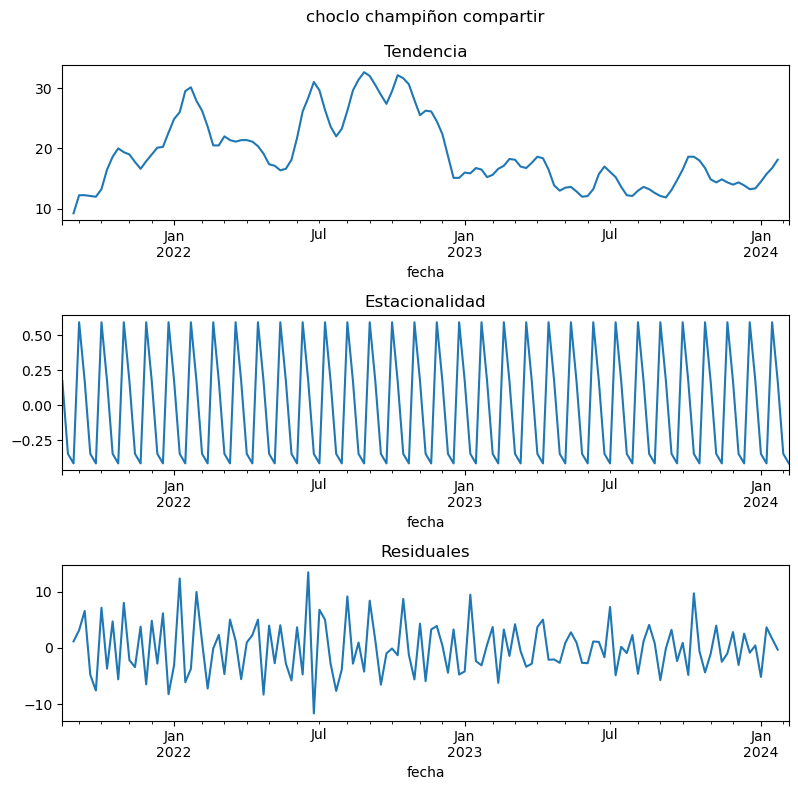

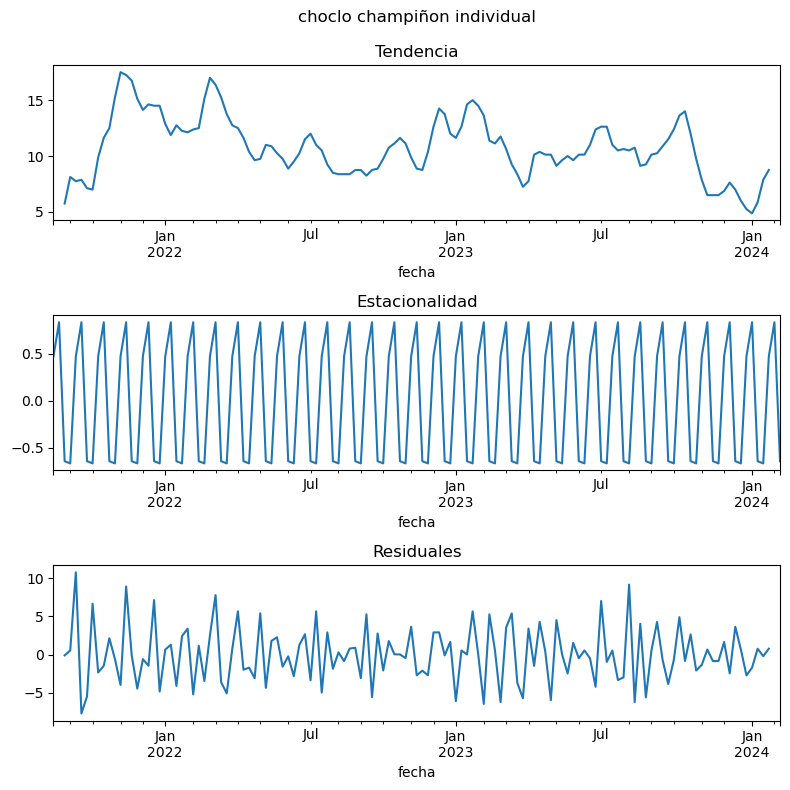

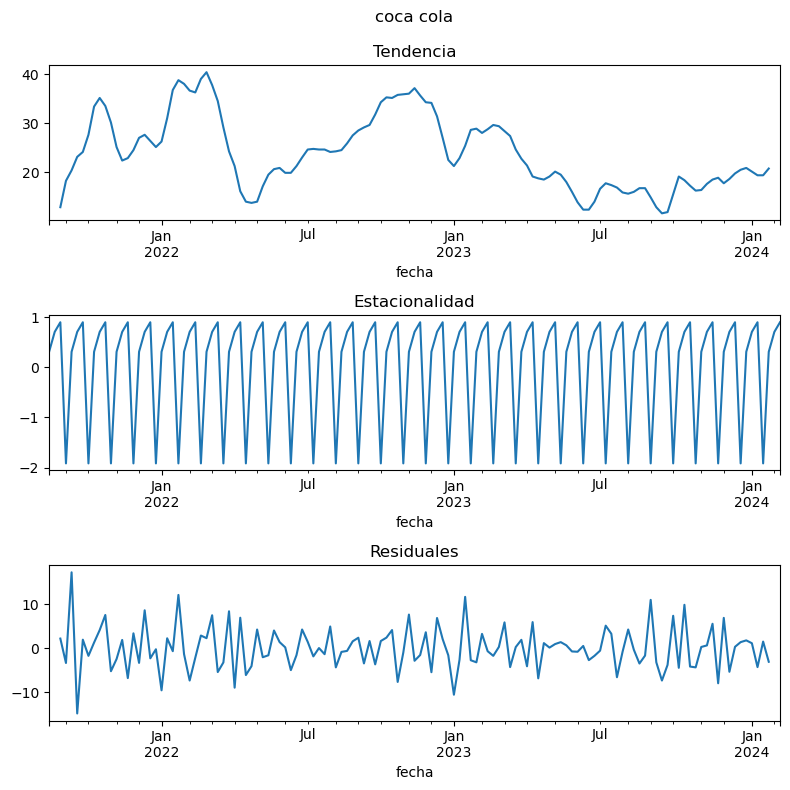

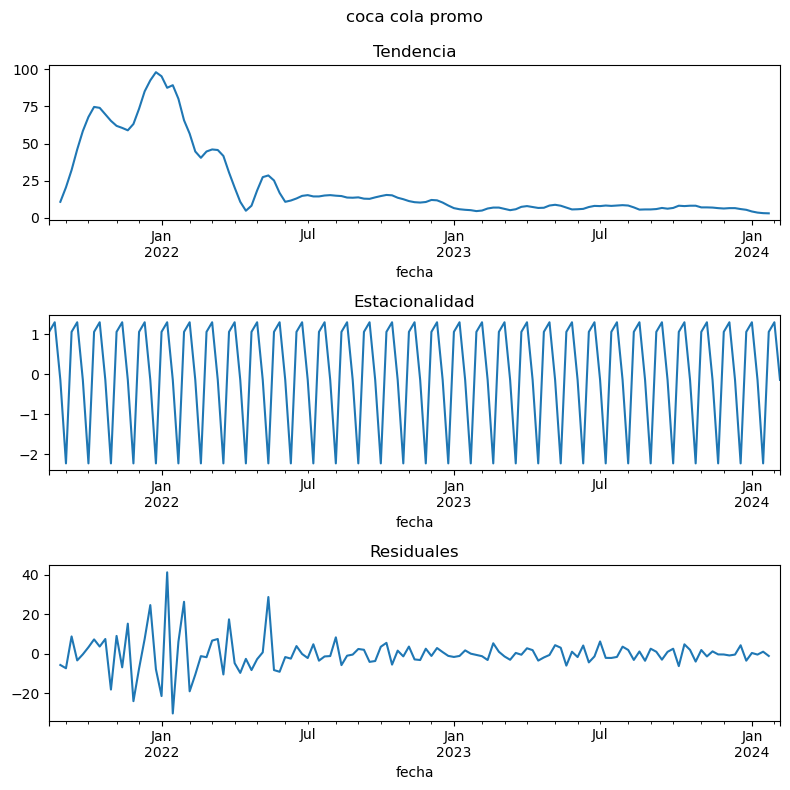

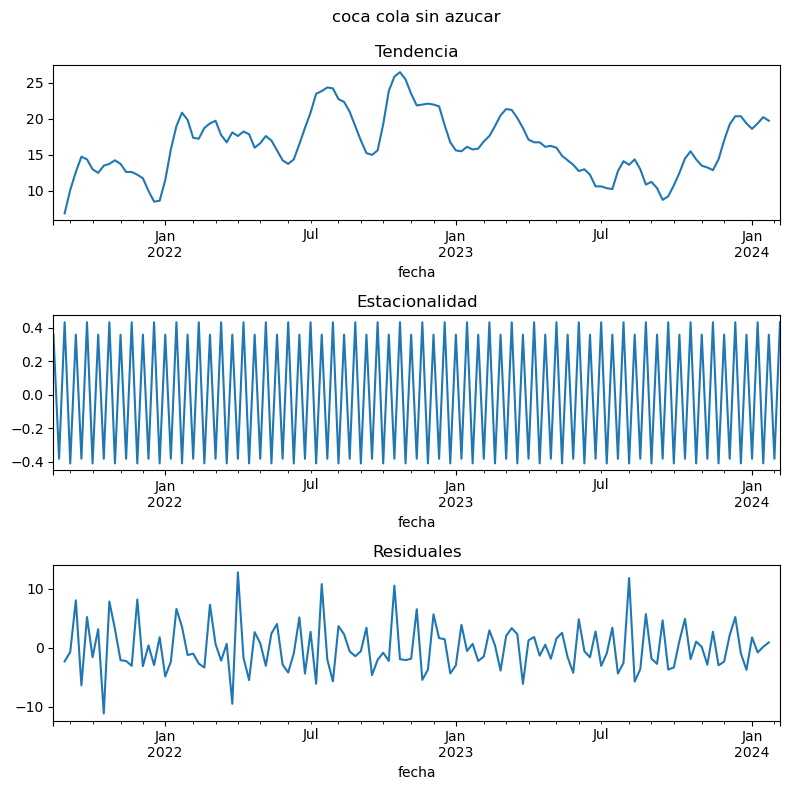

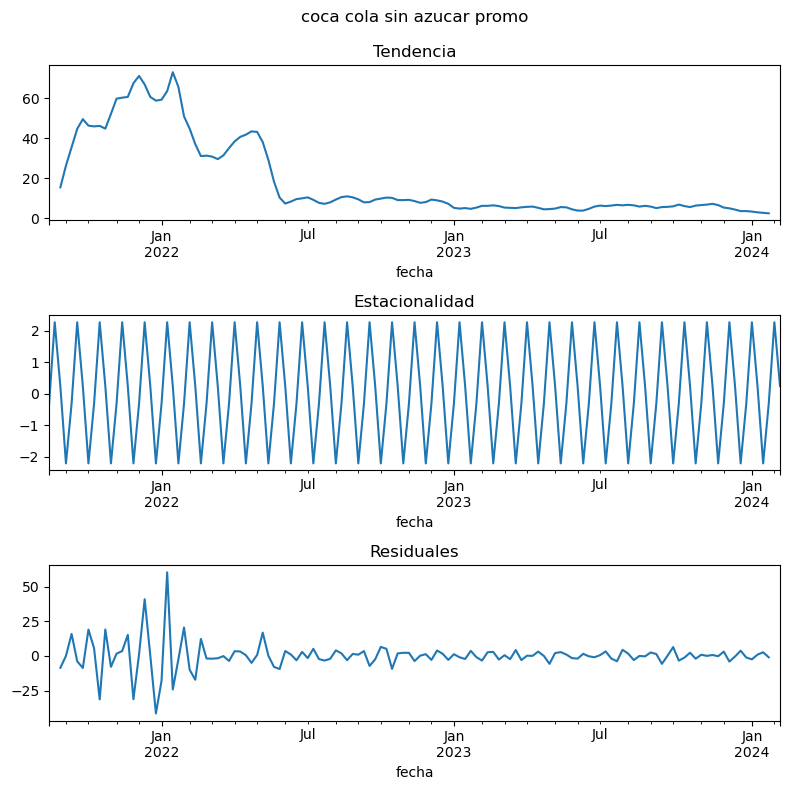

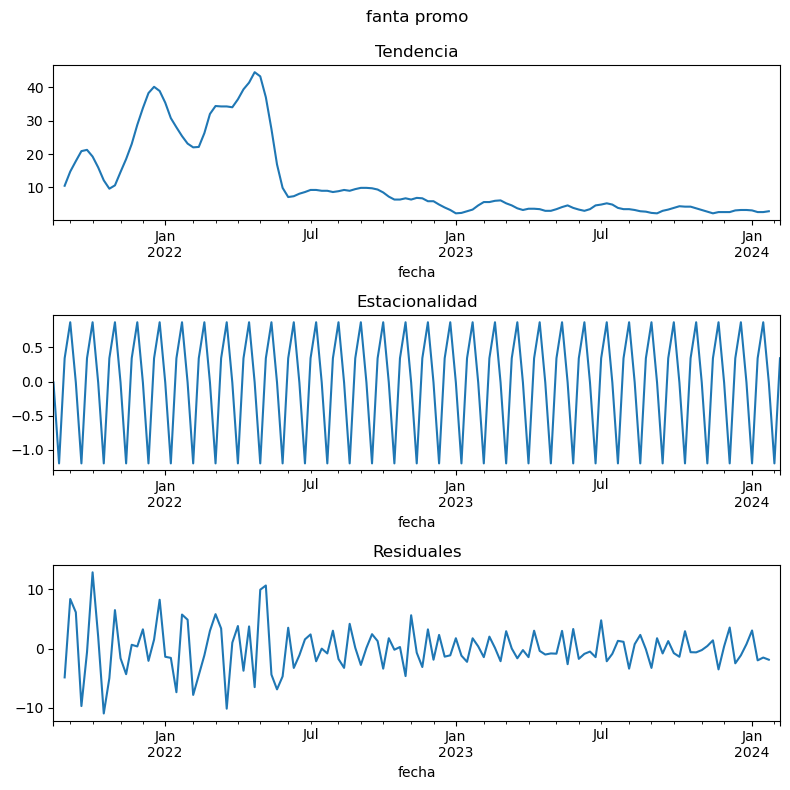

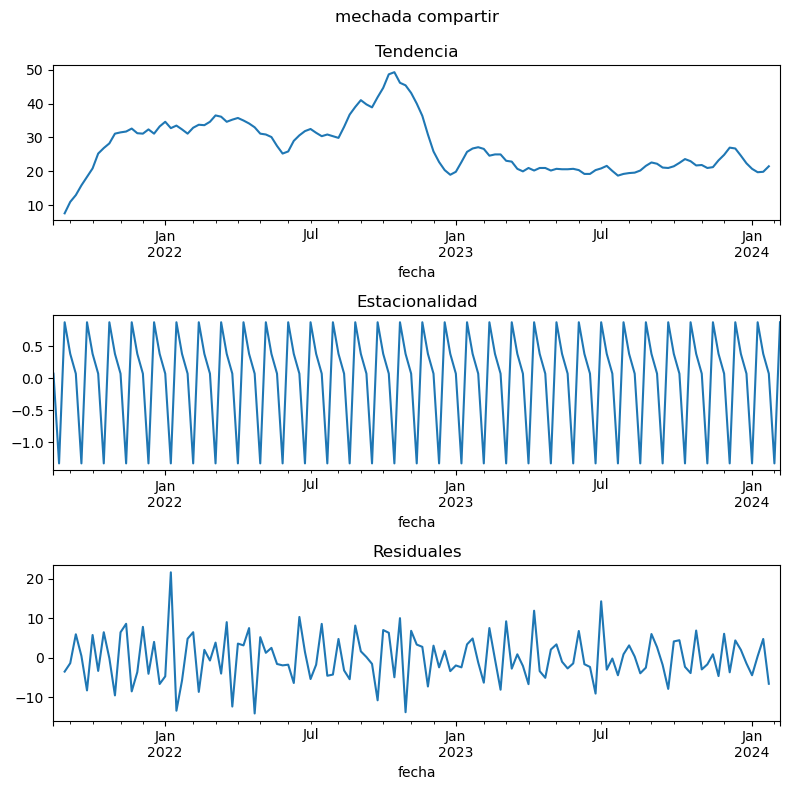

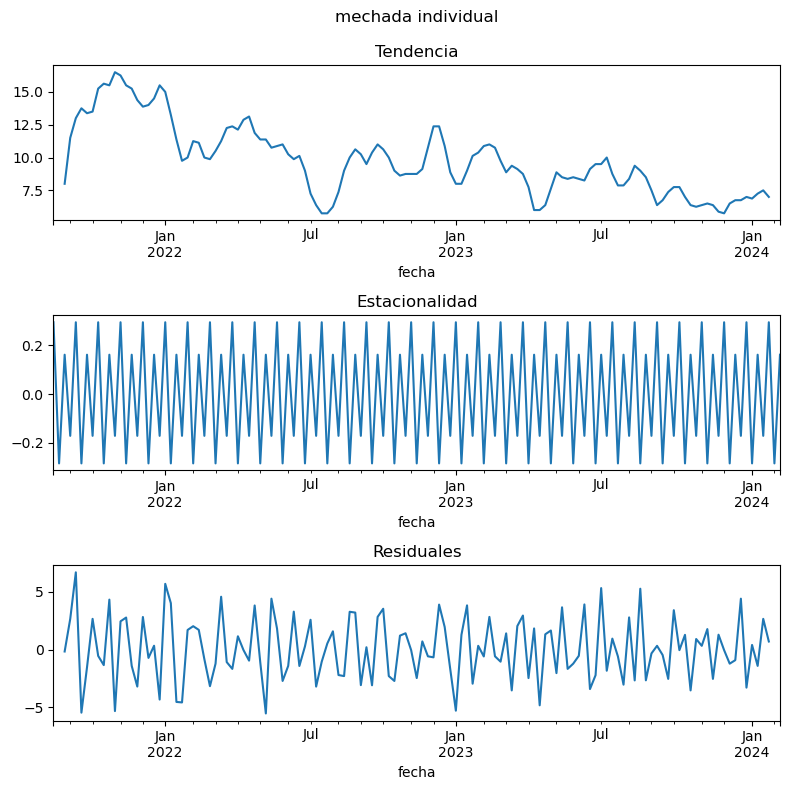

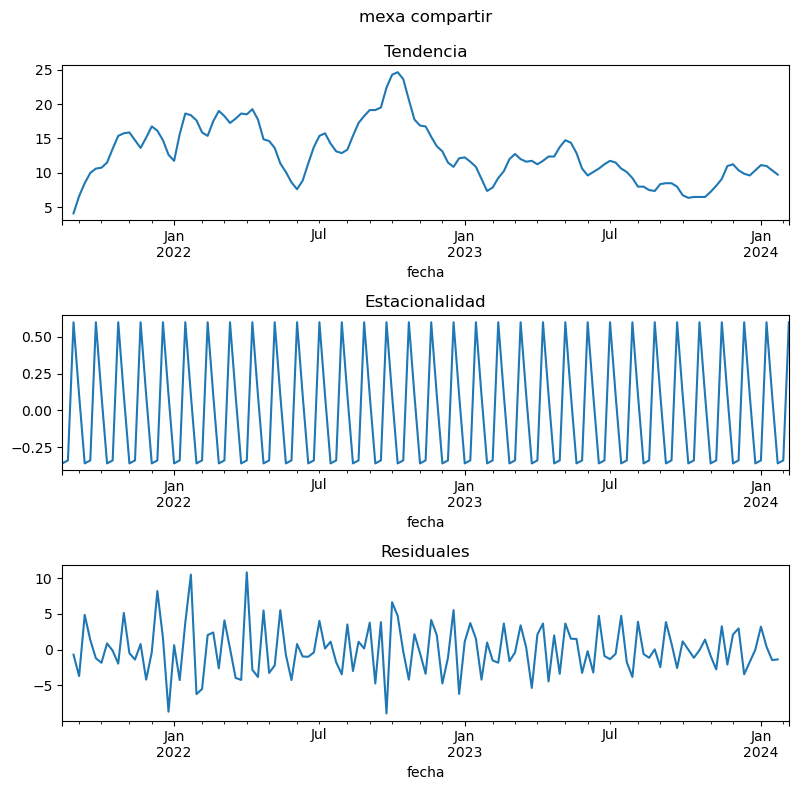

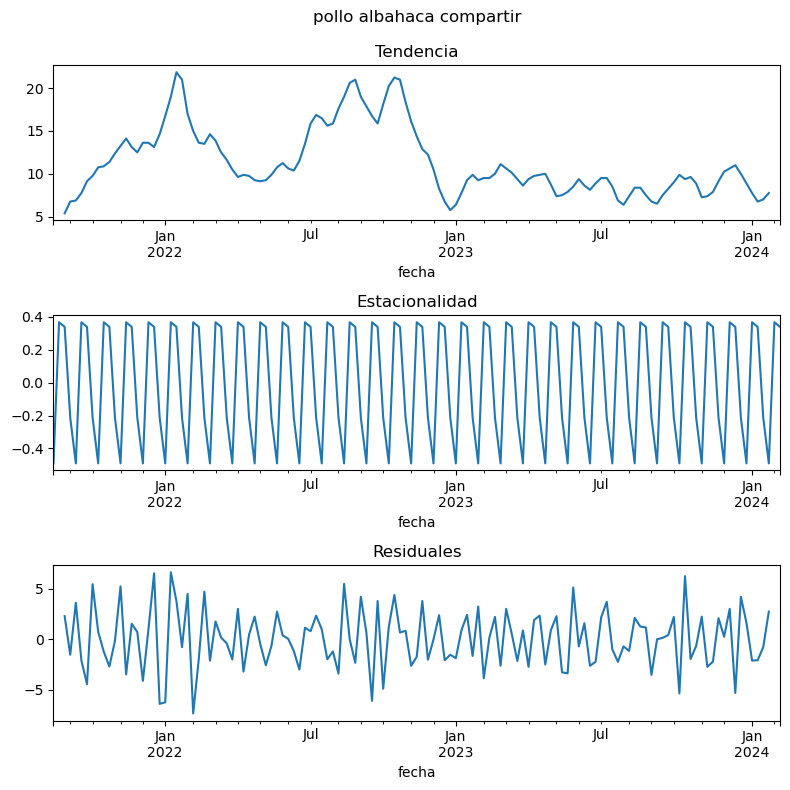

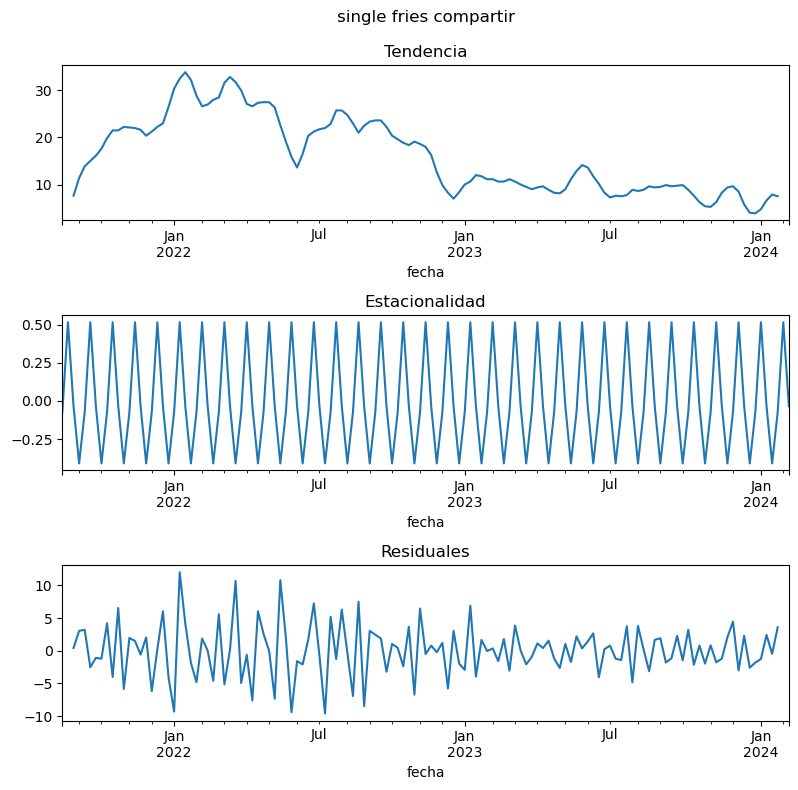

In [25]:
for product in df_pivot.columns[:-1]:
    # Decomposing
    decomposed = seasonal_decompose(df_pivot[product], model='additive', period=4)  # period=4 para patrones mensuales

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.subplot(311)
    plt.title(f'{product}\n\nTendencia')  
    decomposed.trend.plot()

    plt.subplot(312)
    plt.title('Estacionalidad')
    decomposed.seasonal.plot()

    plt.subplot(313)
    plt.title('Residuales')
    decomposed.resid.plot()

    plt.tight_layout()
    plt.show()

    print("\n")

Hemos observado que existe estacionalidad mensualmente, es decir, hay un comportamiento que se repite mensualmente para cada producto, como estamos trabajando con diversos productos, no podemos capturar detalladamente el comportamiento. Incluiremos en nuestro modelo el ajuste del parametro 'm' para modelos autorima donde podremos especificar el numero para el cual encontramos tendencia. Tambien usaremos un suavizado aplicando la media movial ya que muchos prodcutos presentan mucho ruido lo que implica valores atipicos. 

In [26]:
window_size = 3  # Tamaño de la ventana para la media móvil

# Aplicar suavizado de media móvil
df_smoothed = df_pivot.rolling(window=window_size, min_periods=1).mean()

Ahora diseñaremos un codigo capaz de:
Preparar: Primero, tomamos los datos históricos y los dividimos en dos partes: una parte para "entrenar" nuestro modelo (es decir, enseñarle el patrón de ventas) y otra para "probar" qué tan buenas son las predicciones del modelo.

Predecir paso a paso: Luego, comenzamos a predecir las ventas semana por semana, utilizando un modelo avanzado llamado ARIMA, que es especialmente bueno para predecir cómo cambian las cosas a lo largo del tiempo, como las ventas semanales. Cada vez que hacemos una predicción, la comparamos con lo que realmente sucedió (nuestros datos de prueba) y usamos esta información real para mejorar nuestras predicciones futuras.

Evaluar: Después de hacer todas nuestras predicciones, calculamos un valor llamado RMSE (Error Cuadrático Medio Raíz), que básicamente nos dice cuán cerca estuvieron nuestras predicciones de las ventas reales. Un valor más bajo significa que nuestras predicciones fueron más precisas.

Repetir para cada producto: Hacemos este proceso para cada producto individualmente, almacenando cuán bien pudimos predecir su demanda (el RMSE) y guardando el modelo específico que usamos para esas predicciones.

Visualizar: Finalmente, para cada producto, mostramos un gráfico que compara nuestras predicciones con las ventas reales, lo que nos da una representación visual de qué tan precisas fueron nuestras predicciones.

RMSE de validación cruzada para 2 SCHOP HEINEKEN: 3.215


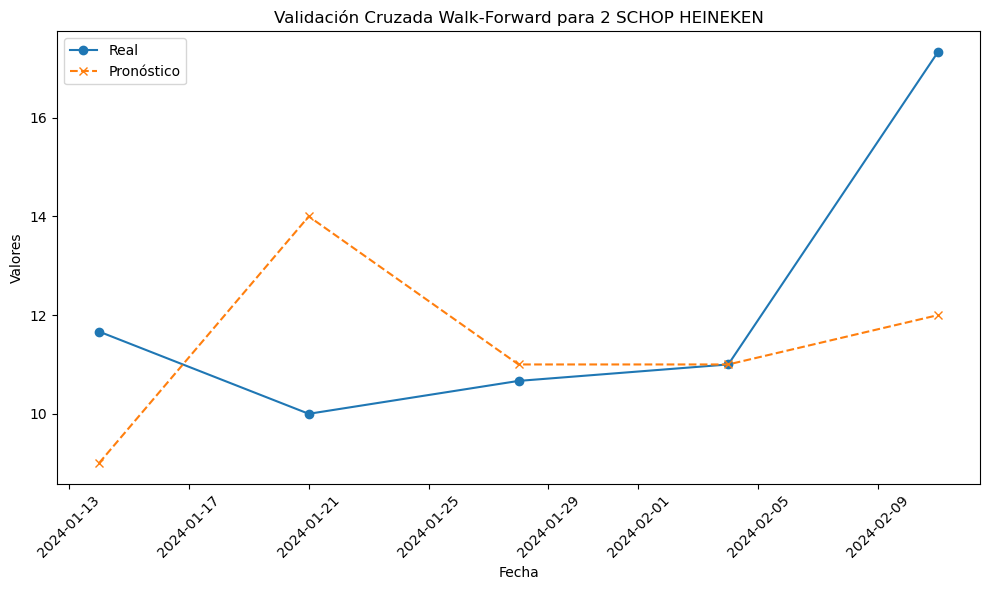

RMSE de validación cruzada para 2 hamburguesas con papas + 2 bebidas: 0.422


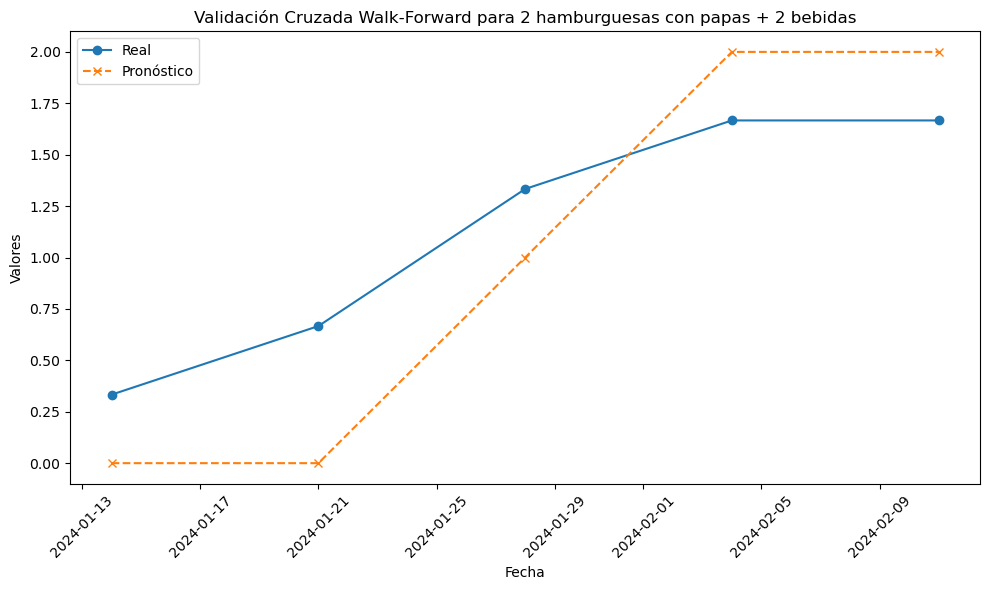

RMSE de validación cruzada para 2 papas grandes + 2 bebidas: 1.445


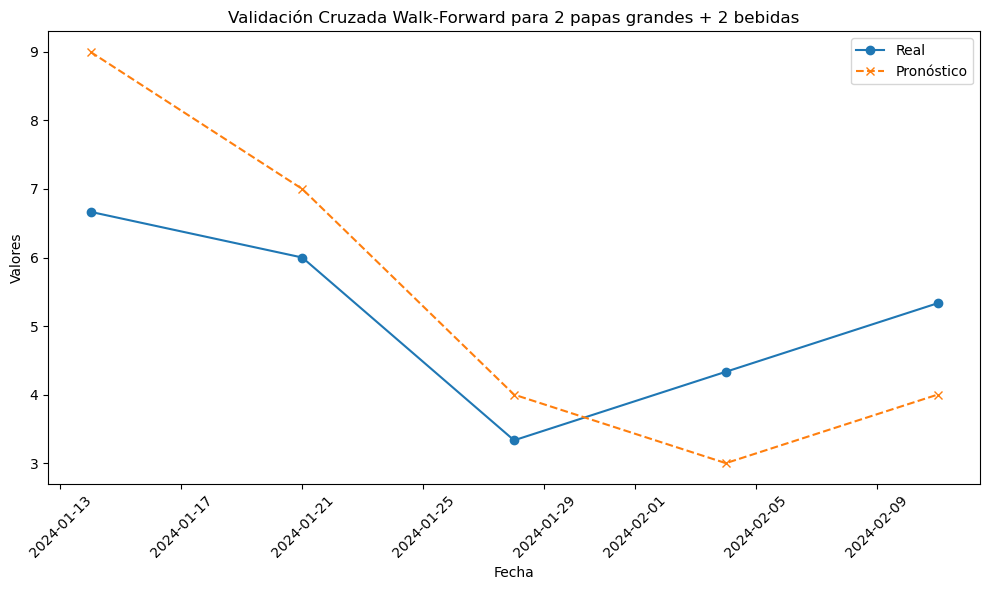

RMSE de validación cruzada para Cheddar: 1.183


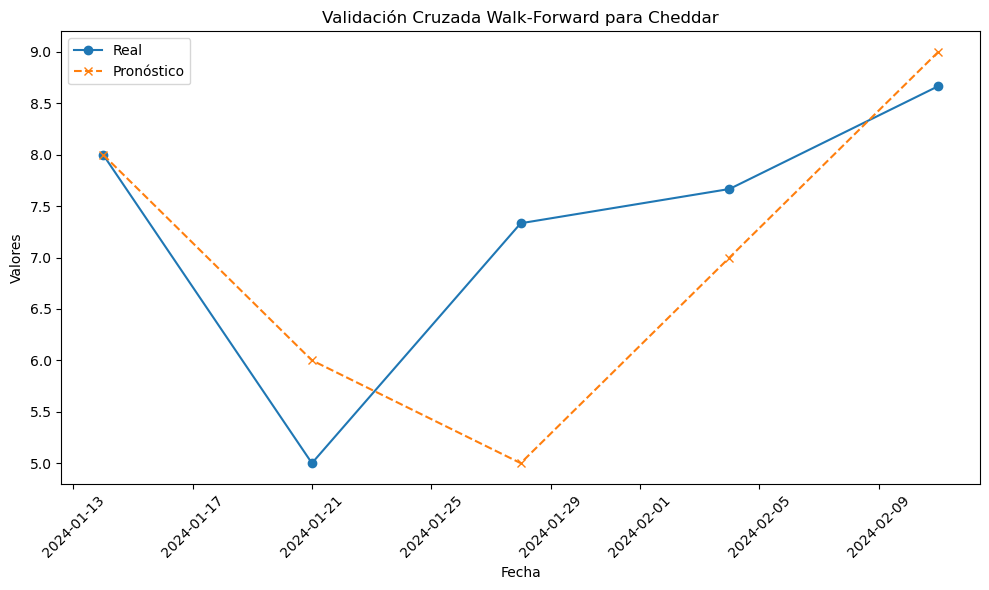

RMSE de validación cruzada para Chelada: 3.409


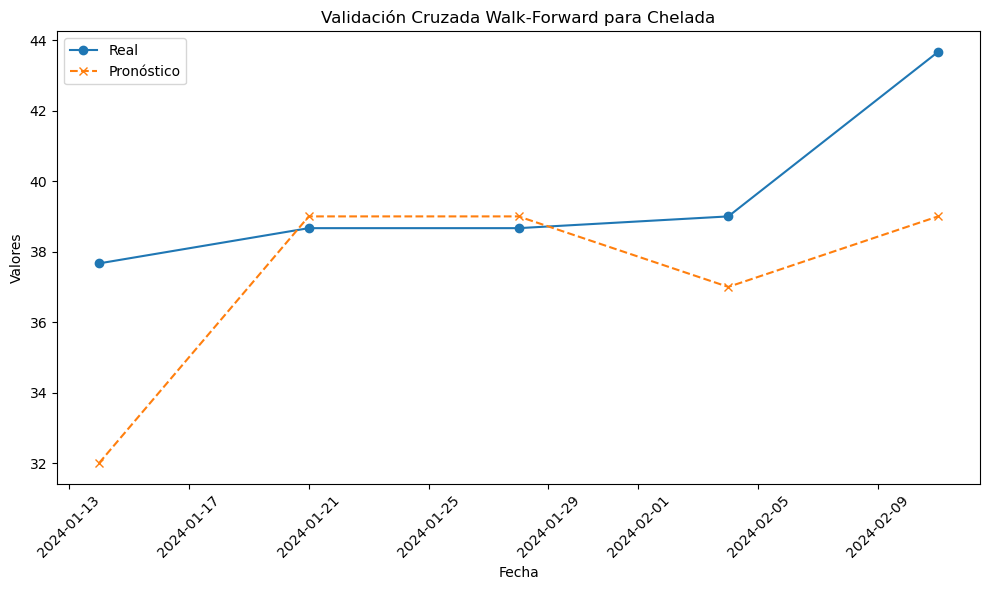

RMSE de validación cruzada para Chicken Box S: 0.365


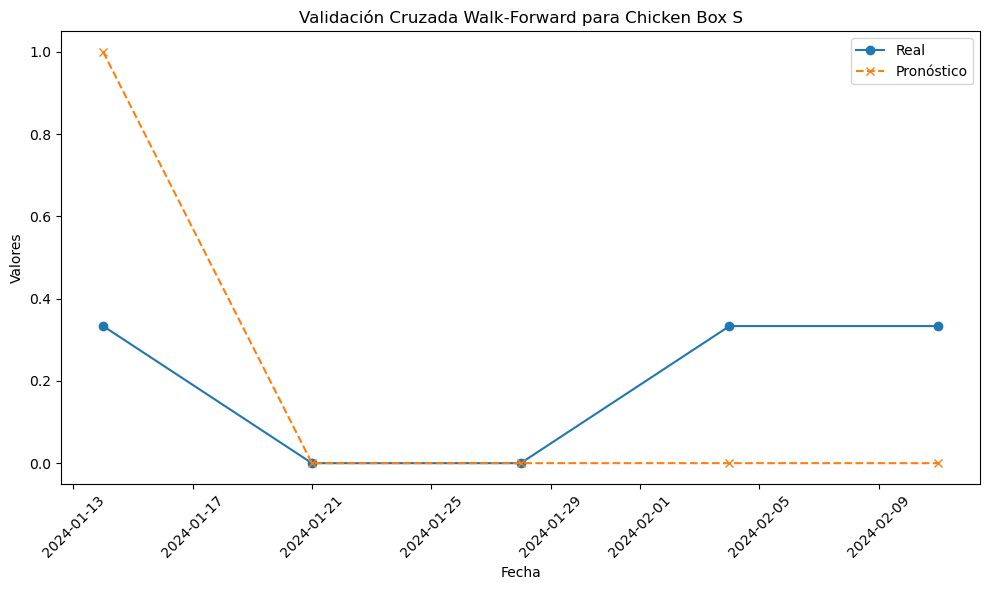

RMSE de validación cruzada para Hamburguesa Americana: 1.751


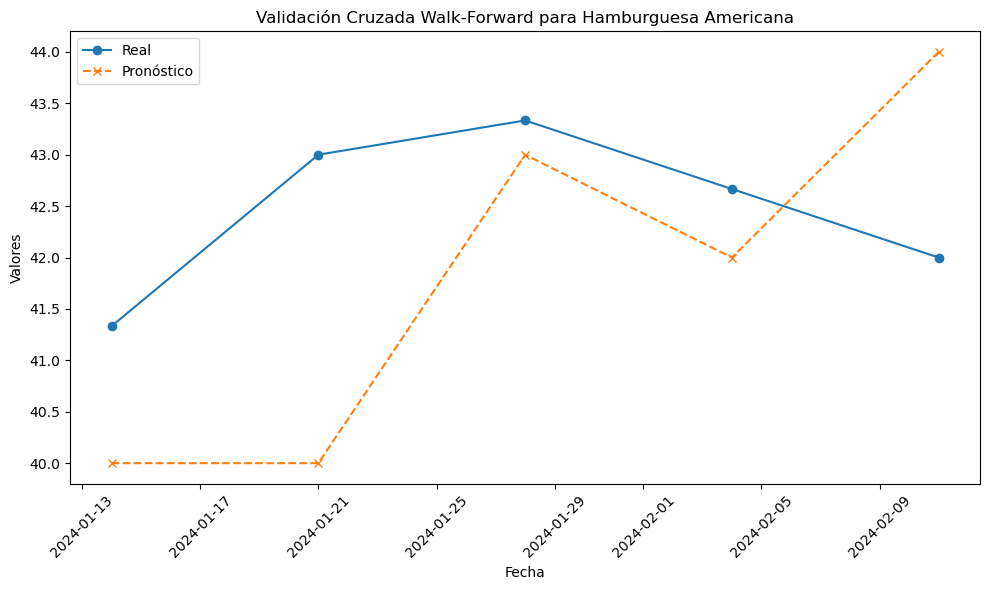

RMSE de validación cruzada para Hamburguesa Clasica: 2.996


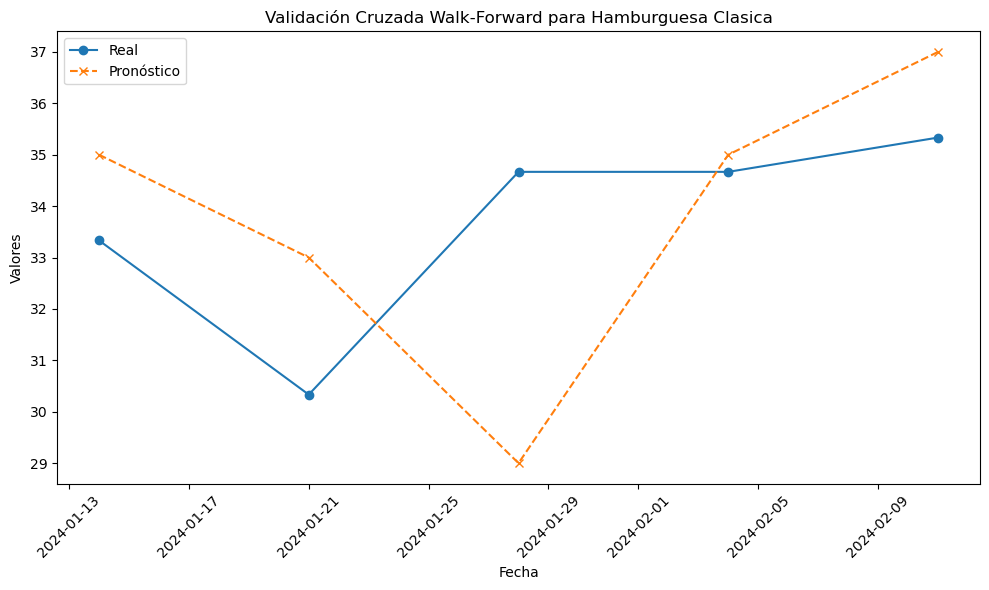

RMSE de validación cruzada para Hamburguesa Clasica con papas promo: 0.667


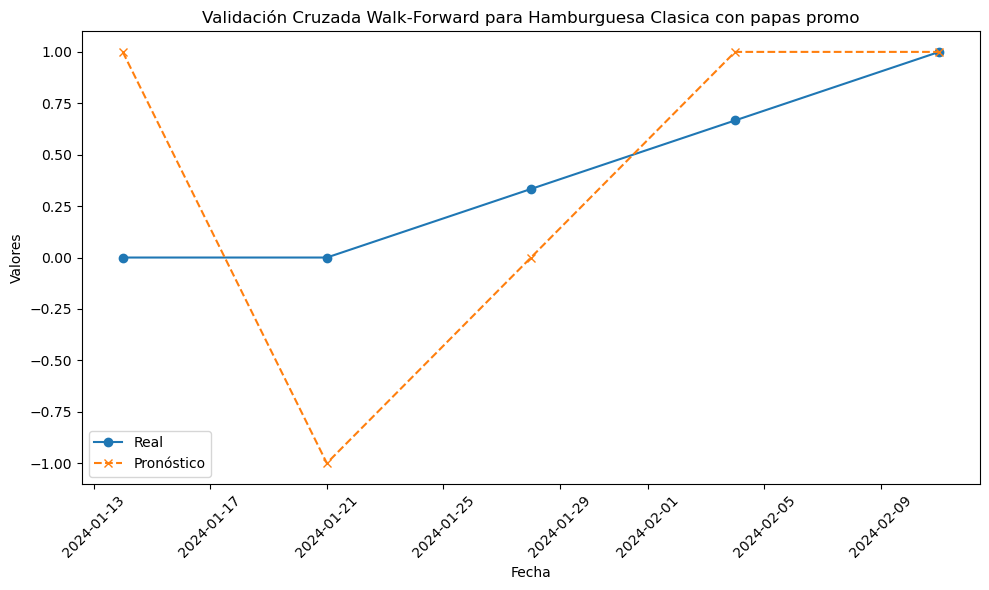

RMSE de validación cruzada para Hamburguesa Hot: 1.317


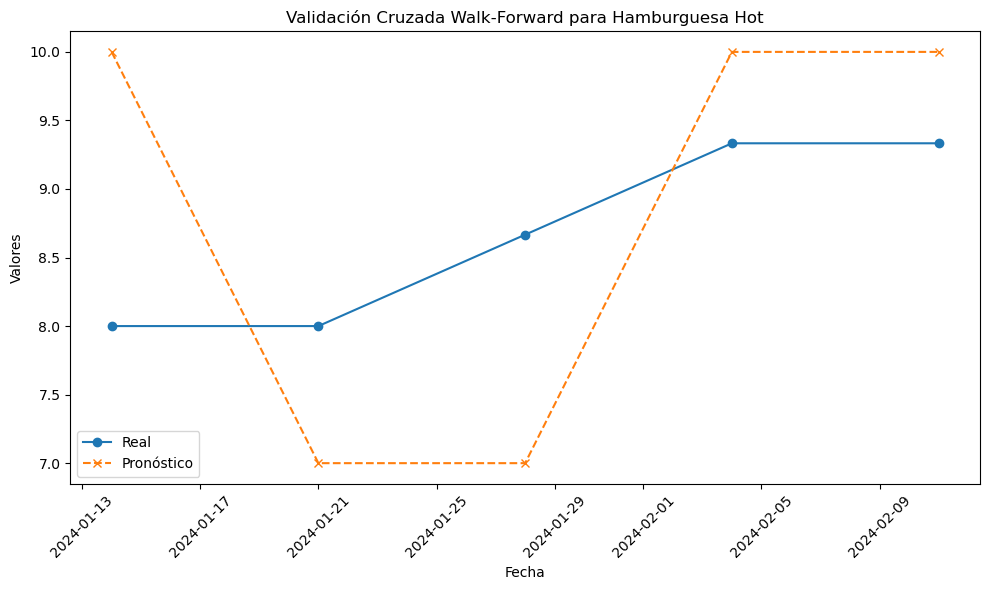

RMSE de validación cruzada para Hamburguesa Vegetariana: 1.626


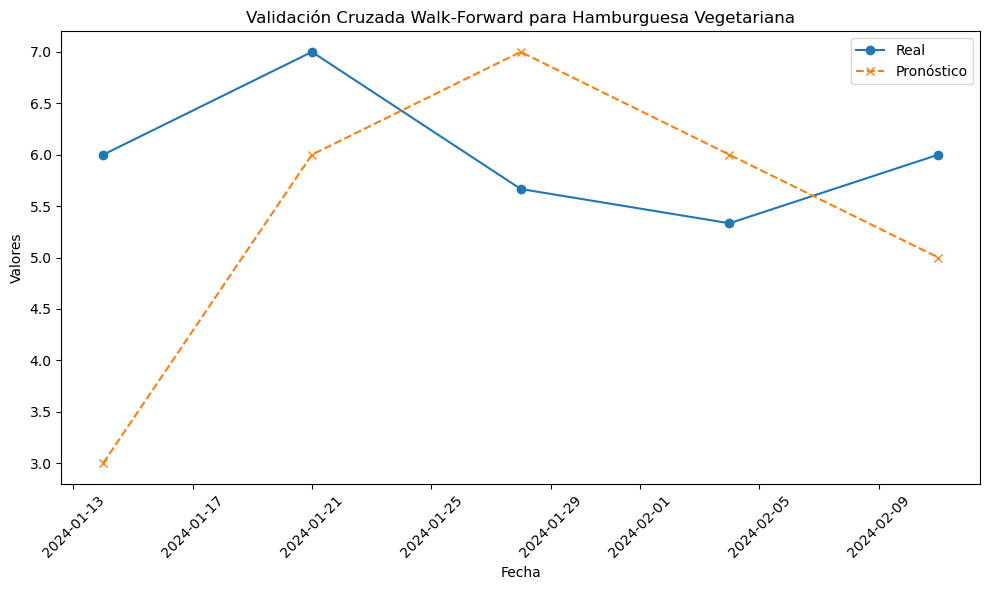

RMSE de validación cruzada para Michelada: 3.682


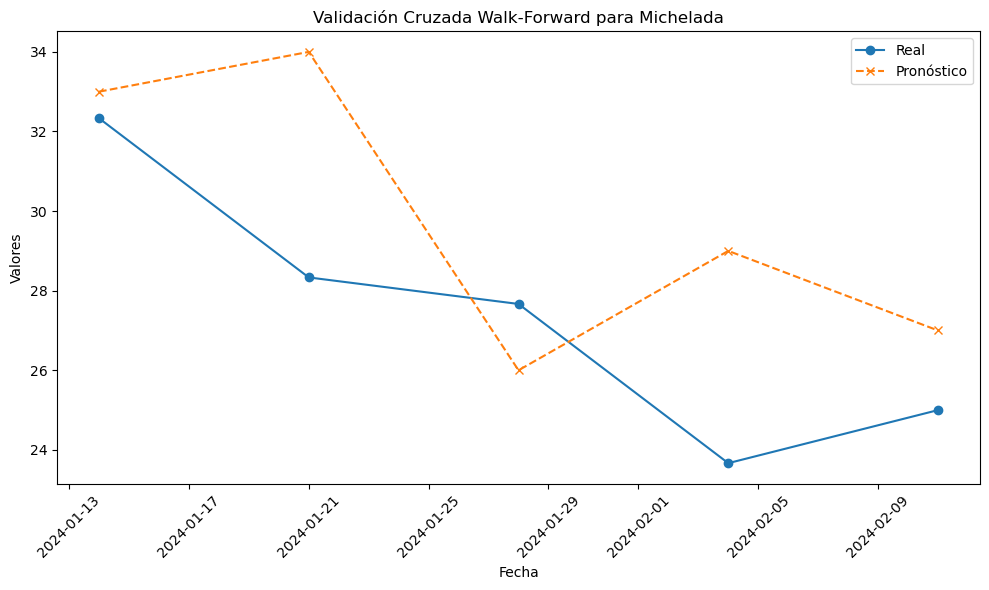

RMSE de validación cruzada para Mistral 35: 5.055


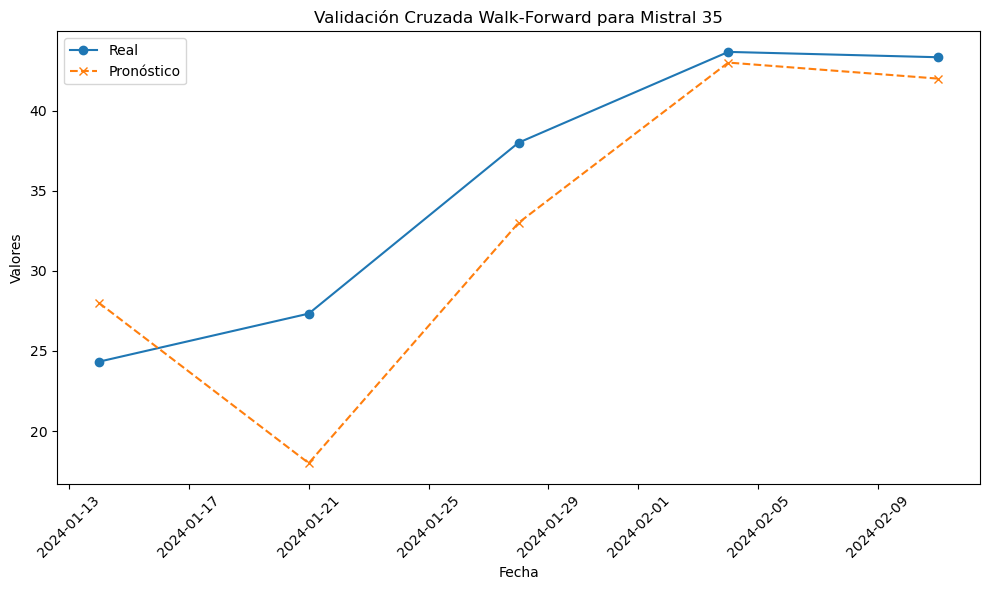

RMSE de validación cruzada para Mistral 40: 3.765


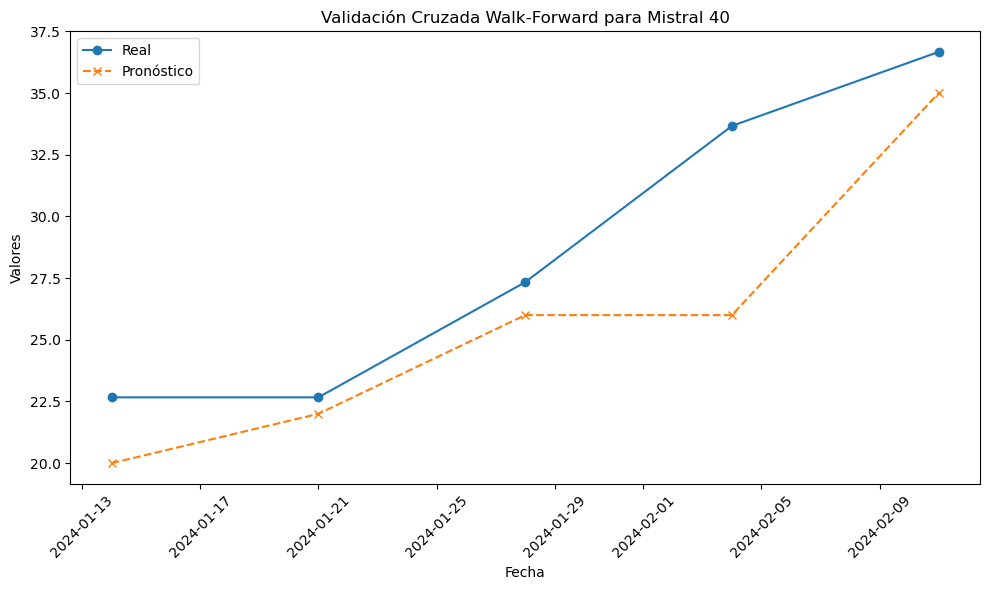

RMSE de validación cruzada para Mojito tradicional: 2.440


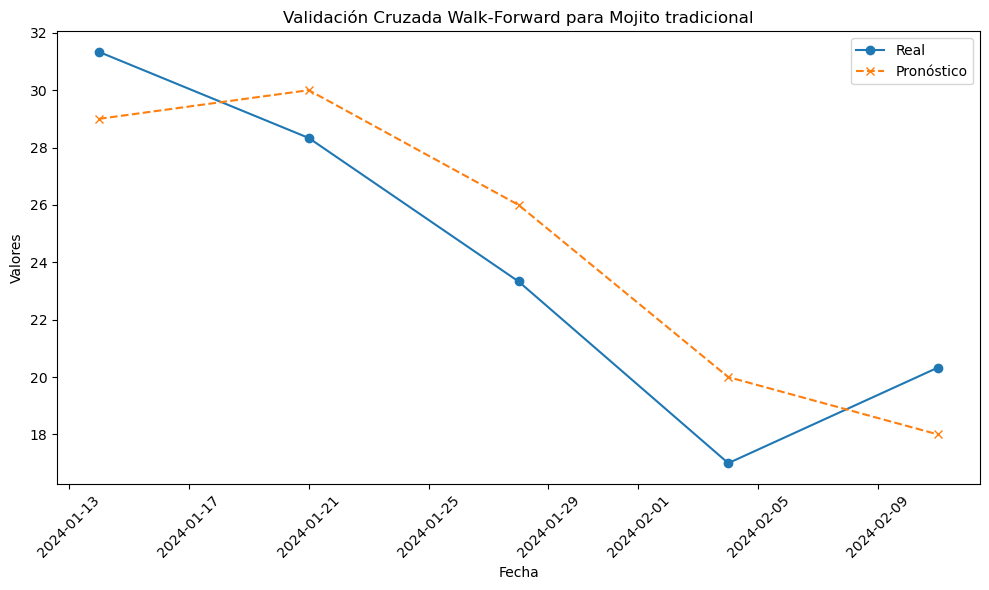

RMSE de validación cruzada para Only Chicken: 2.211


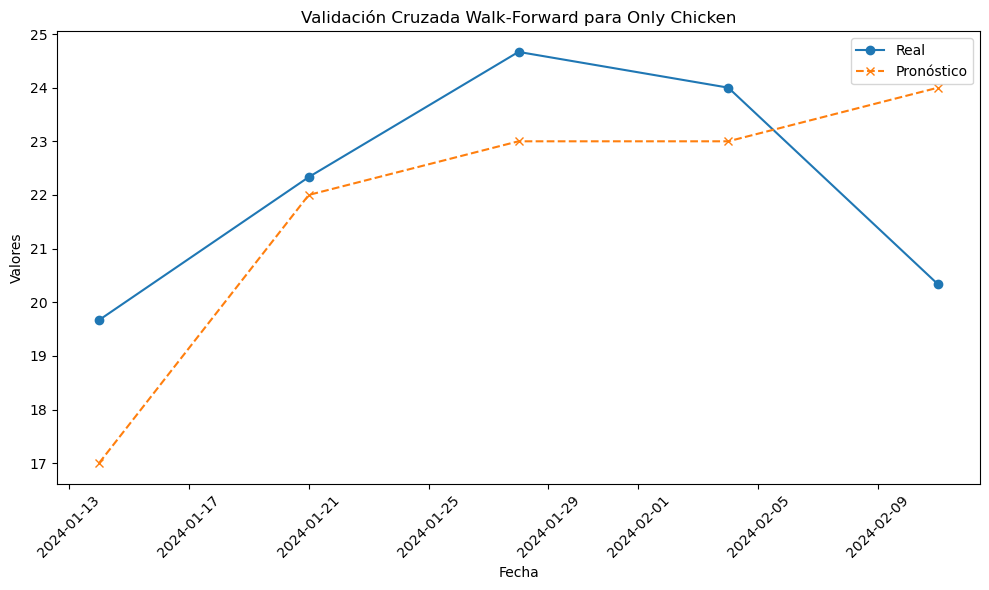

RMSE de validación cruzada para Ramazzotti Spritz: 2.675


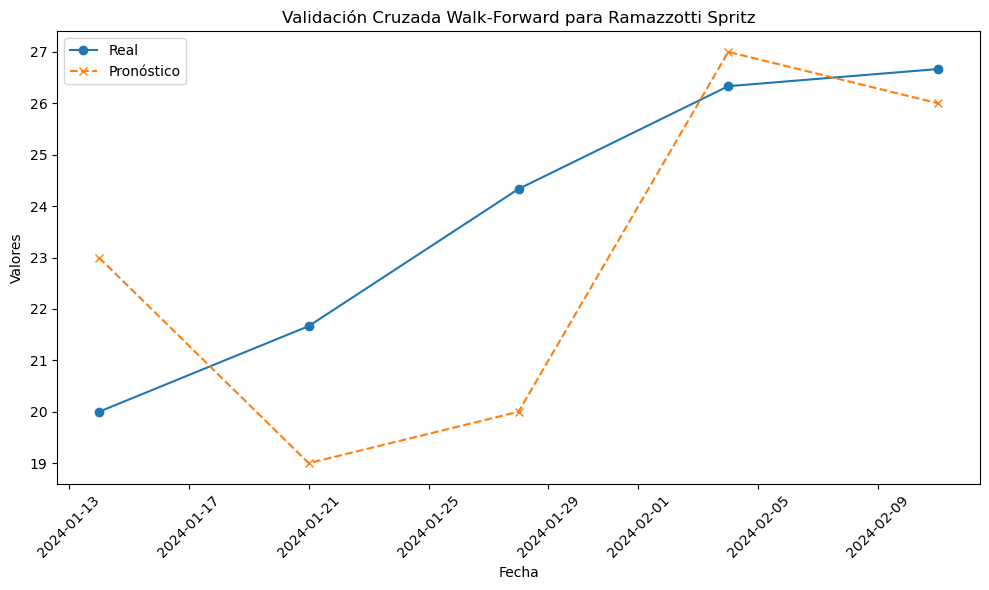

RMSE de validación cruzada para Sandi spritz: 1.838


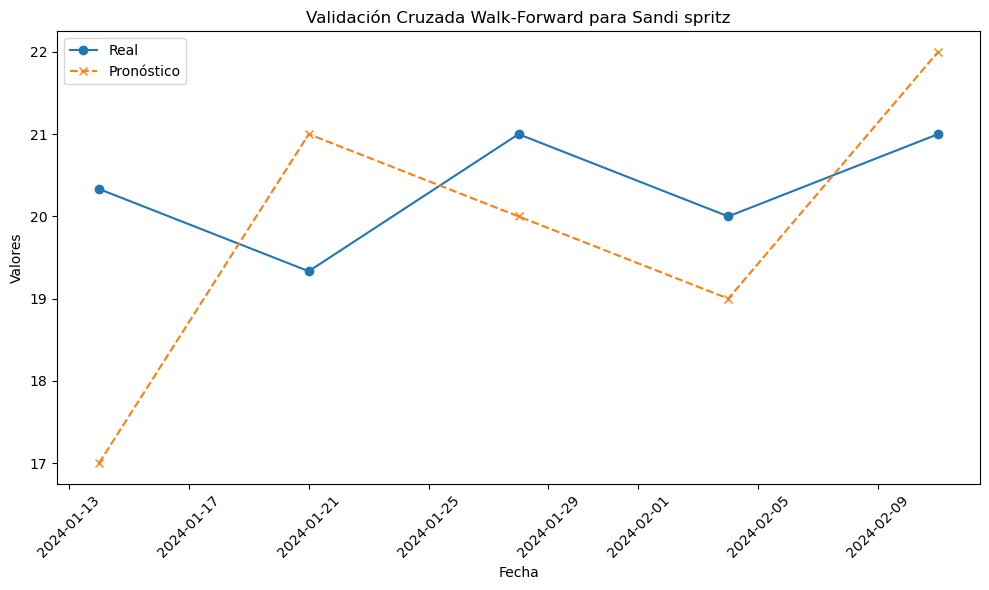

RMSE de validación cruzada para Schop heineken: 7.084


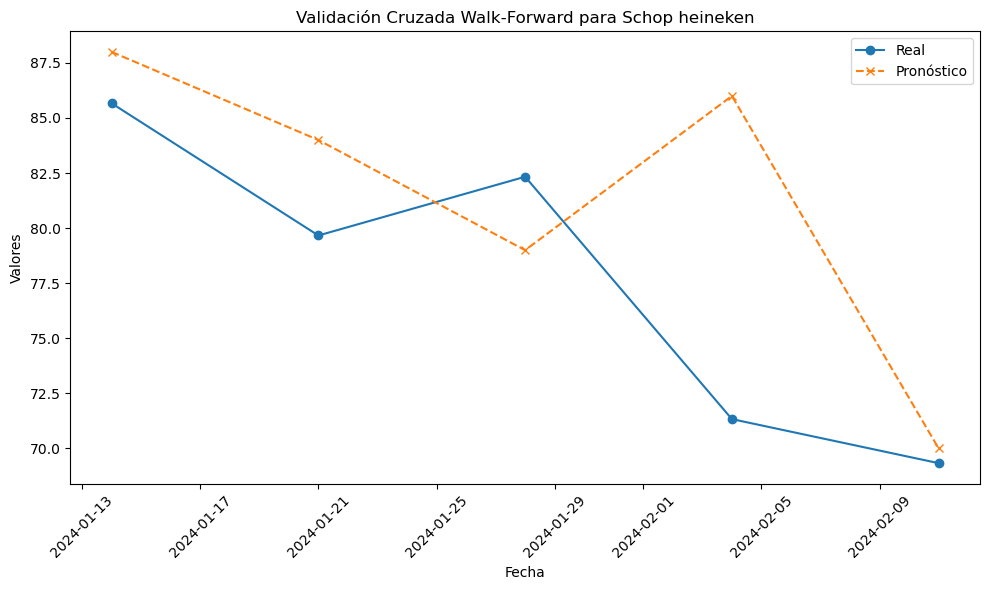

RMSE de validación cruzada para Solsticio: 2.256


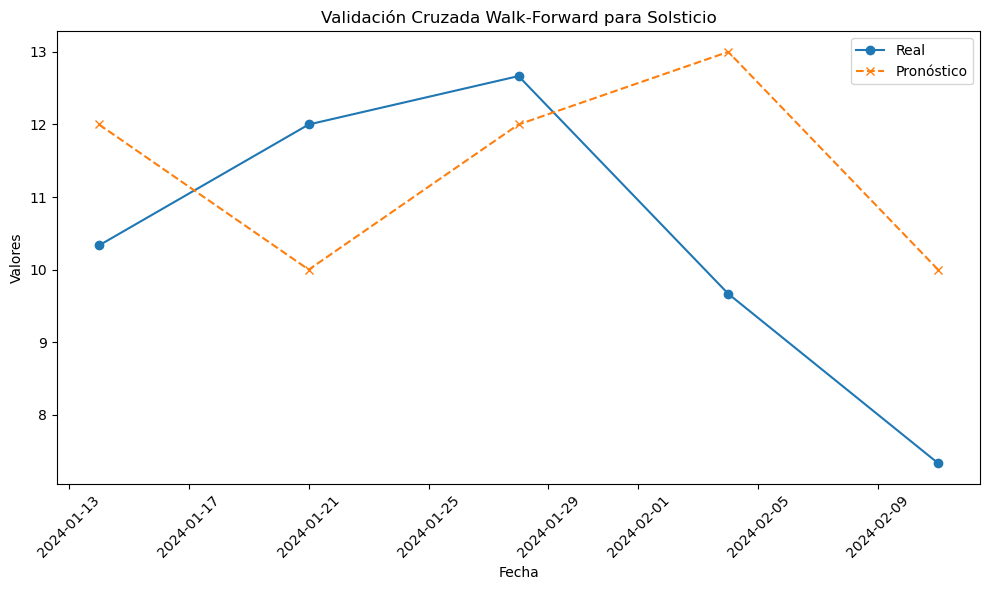

RMSE de validación cruzada para beefie compartir: 2.140


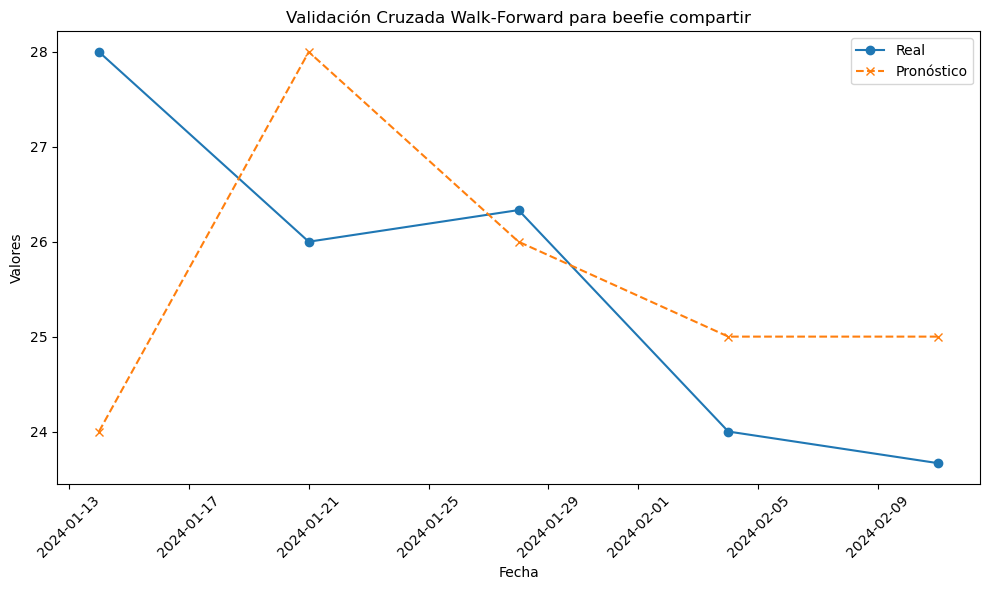

RMSE de validación cruzada para beefie individual: 1.653


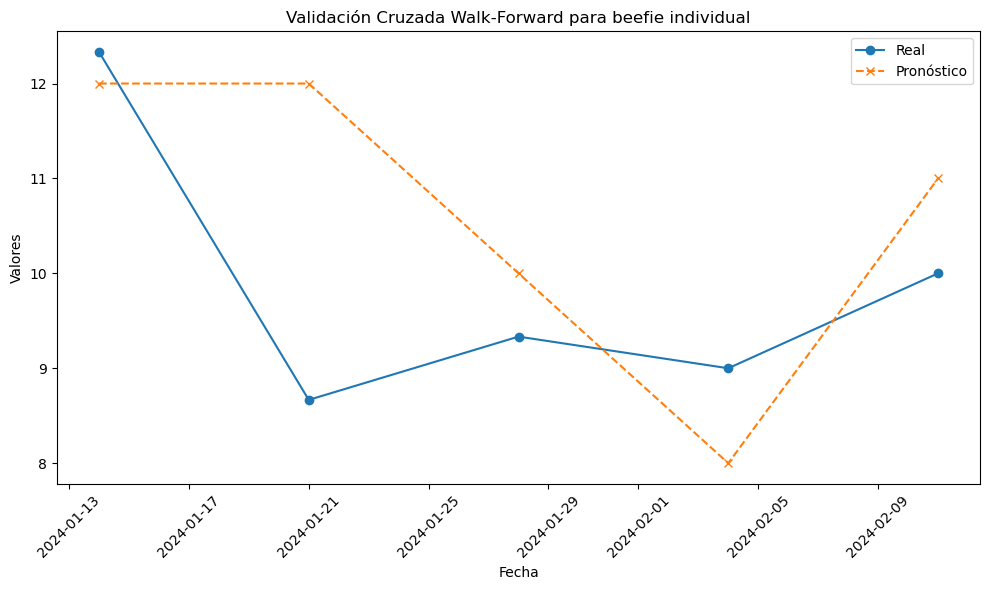

RMSE de validación cruzada para cheese and bacon compartir: 4.415


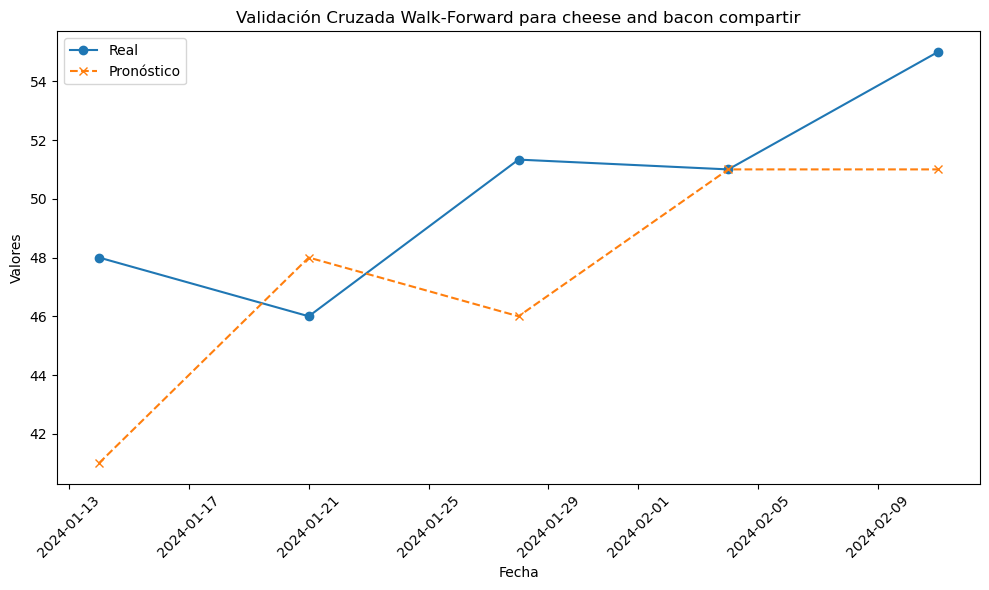

RMSE de validación cruzada para cheese and bacon compartir promo: 1.022


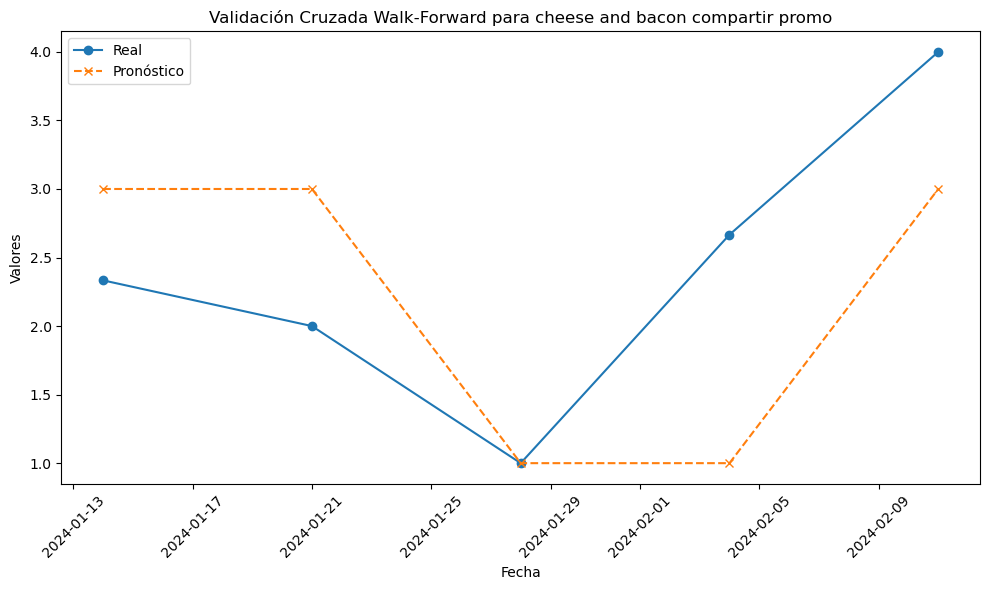

RMSE de validación cruzada para cheese and bacon individual: 1.308


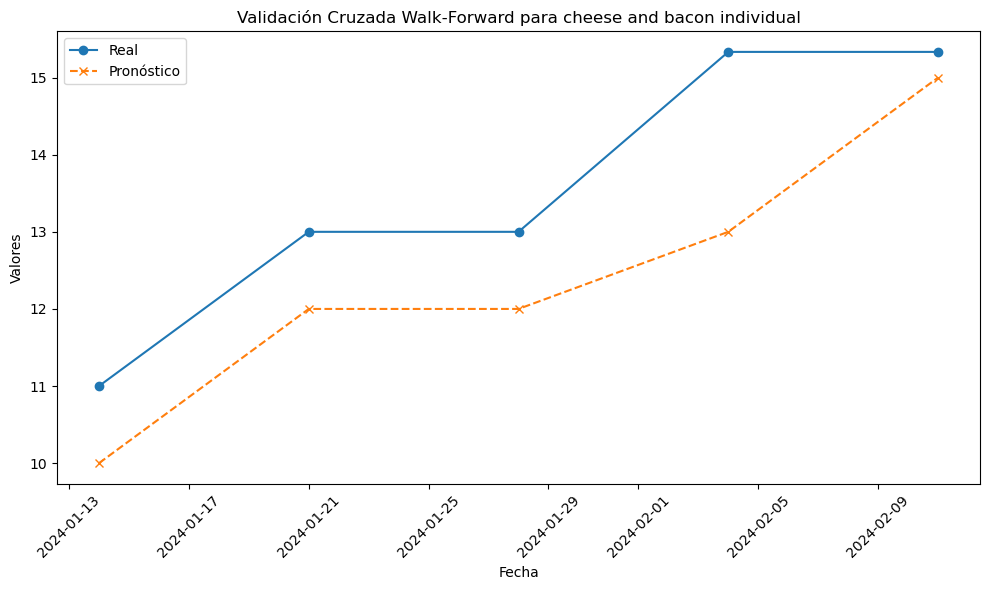

RMSE de validación cruzada para choclo champiñon compartir: 2.160


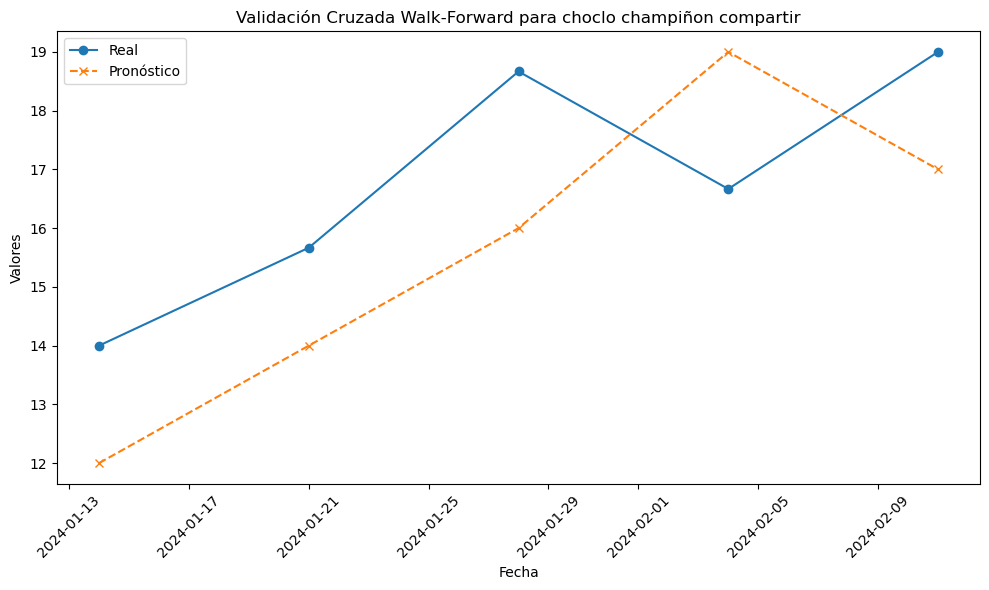

RMSE de validación cruzada para choclo champiñon individual: 1.291


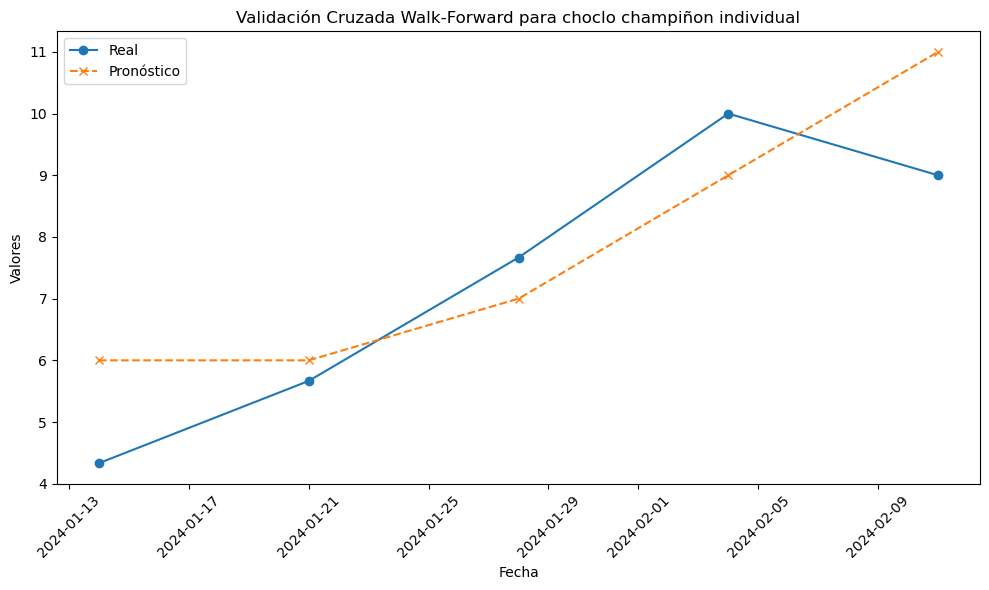

RMSE de validación cruzada para coca cola: 1.758


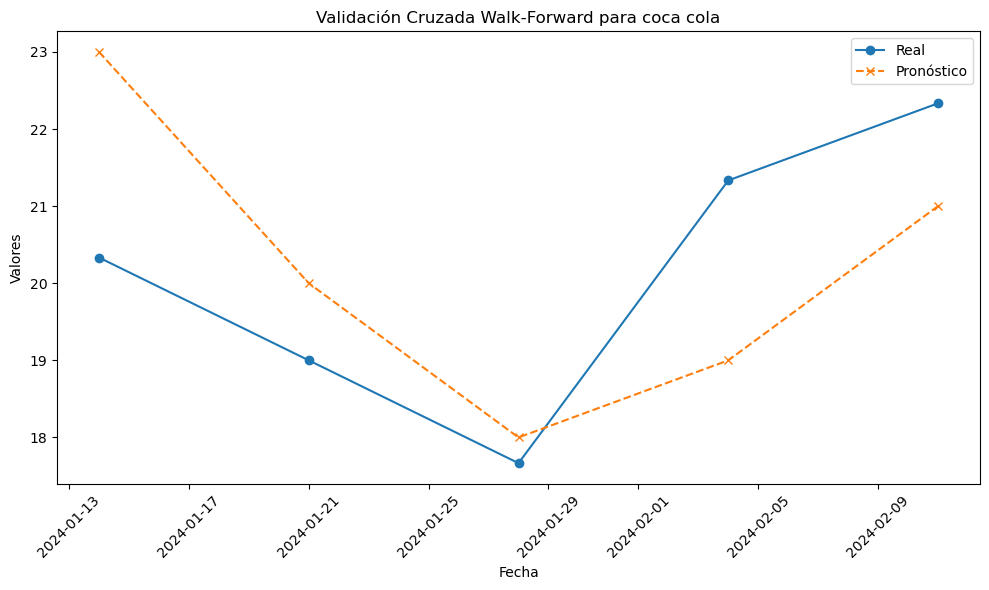

RMSE de validación cruzada para coca cola promo: 0.907


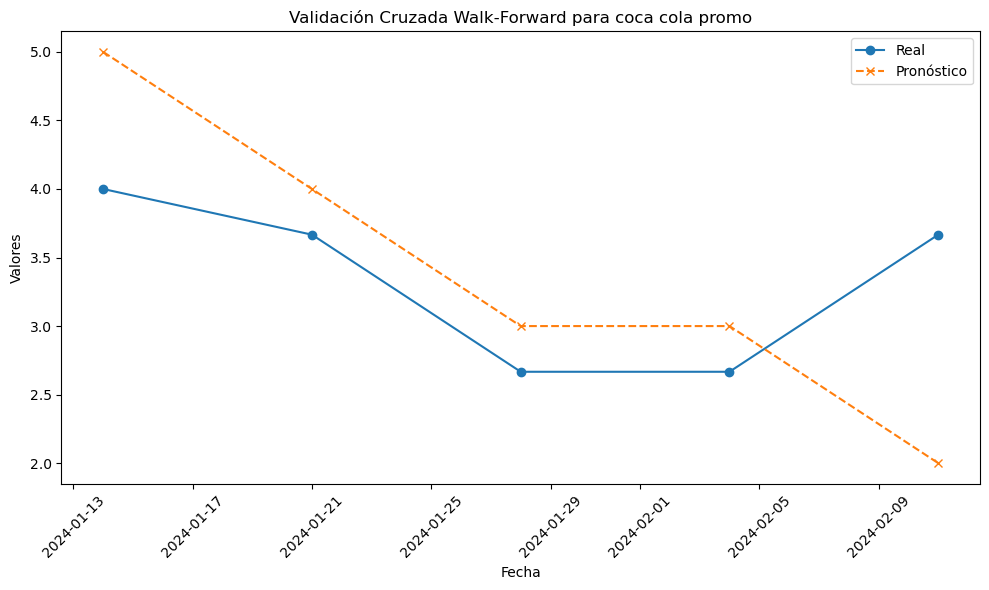

RMSE de validación cruzada para coca cola sin azucar: 1.880


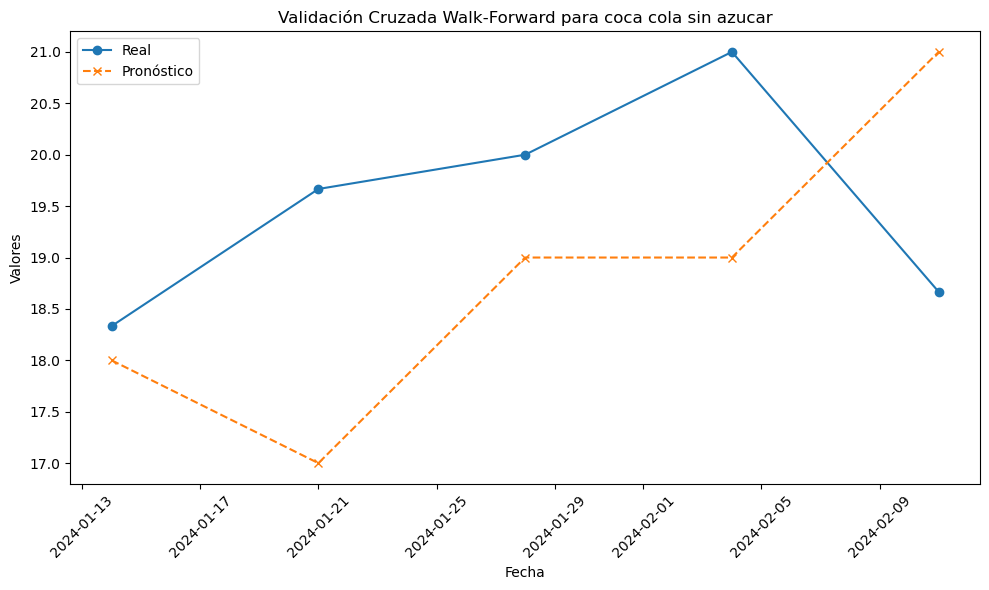

RMSE de validación cruzada para coca cola sin azucar promo: 0.667


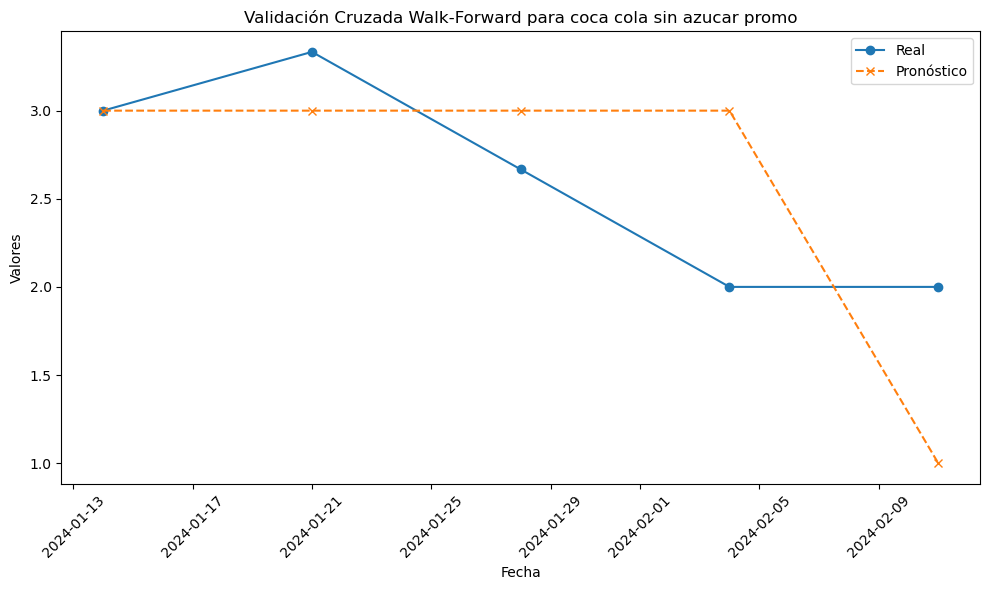

RMSE de validación cruzada para fanta promo: 1.719


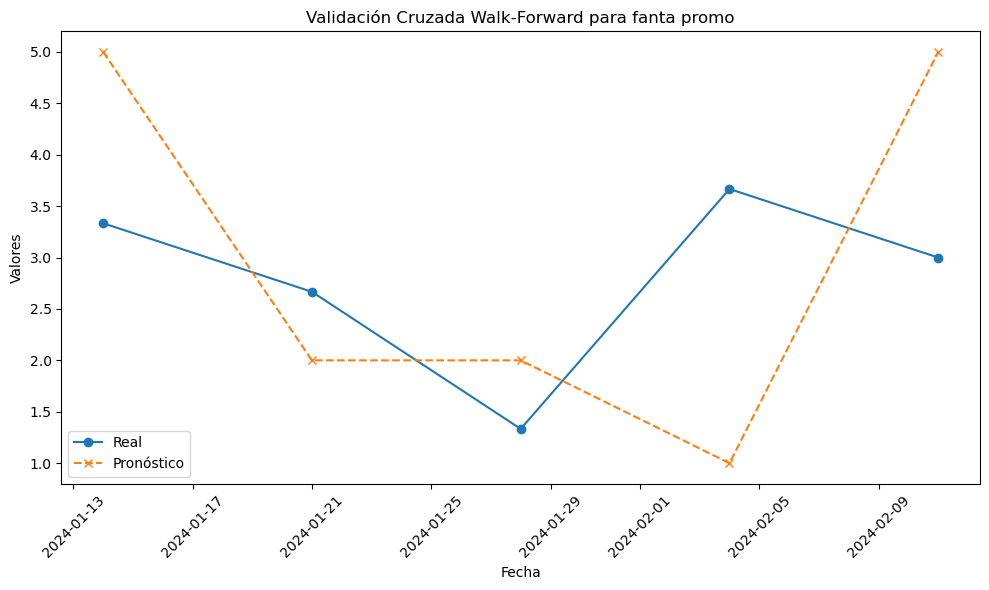

RMSE de validación cruzada para mechada compartir: 2.314


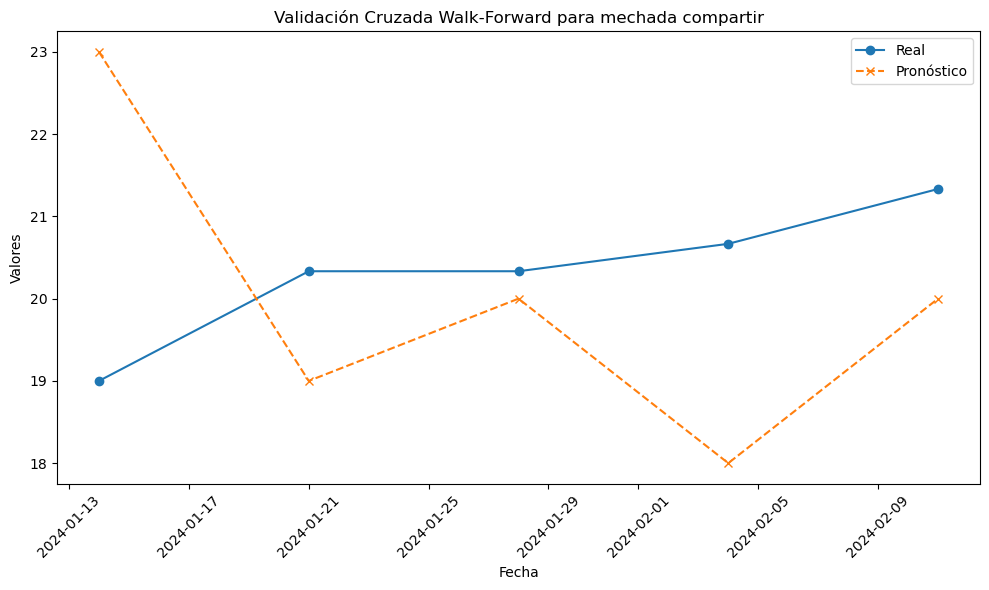

RMSE de validación cruzada para mechada individual: 0.978


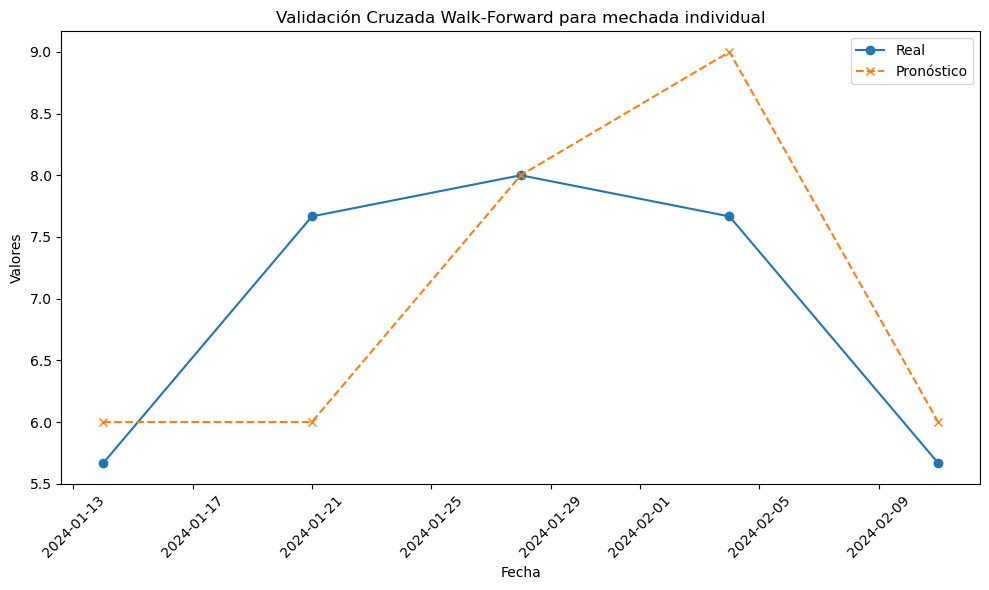

RMSE de validación cruzada para mexa compartir: 1.043


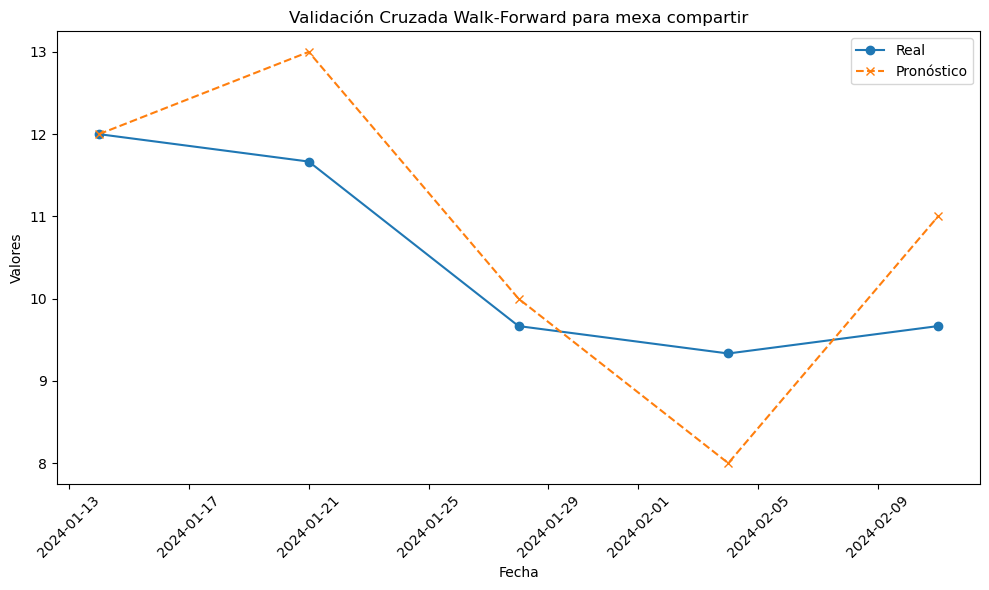

RMSE de validación cruzada para pollo albahaca compartir: 0.789


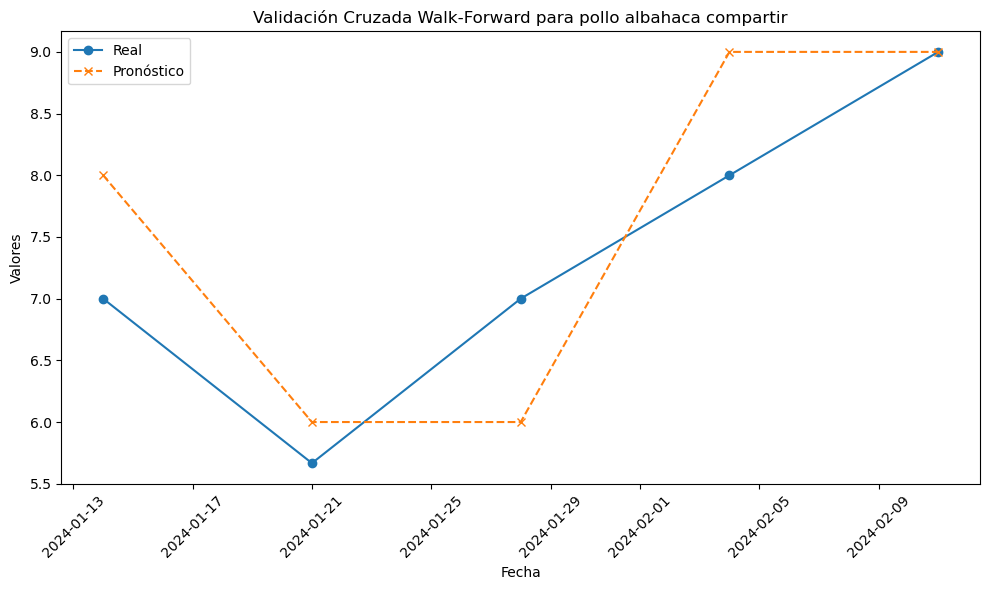

RMSE de validación cruzada para single fries compartir: 0.919


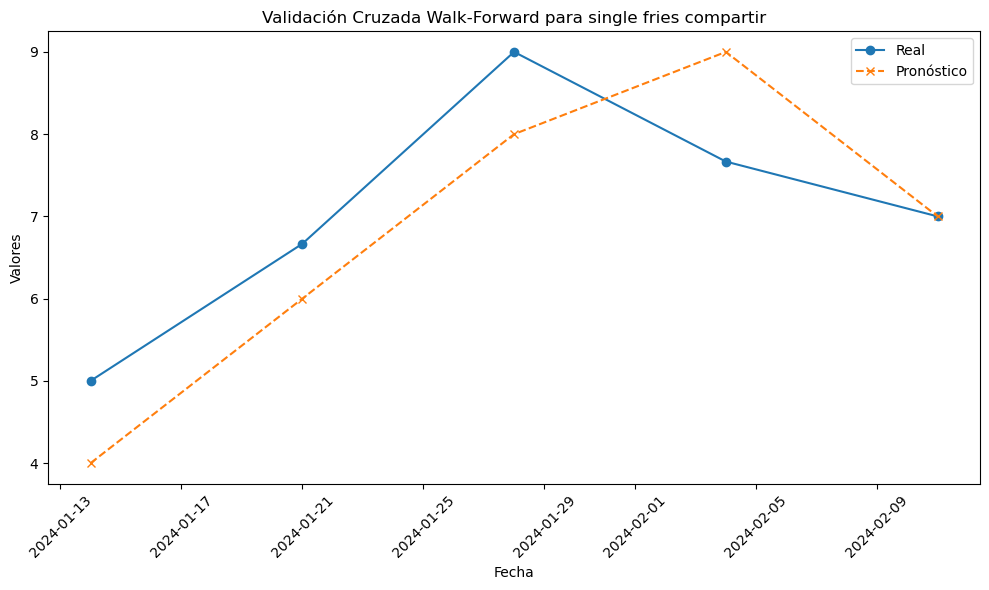

RMSE de validación cruzada para veggie compartir: 1.430


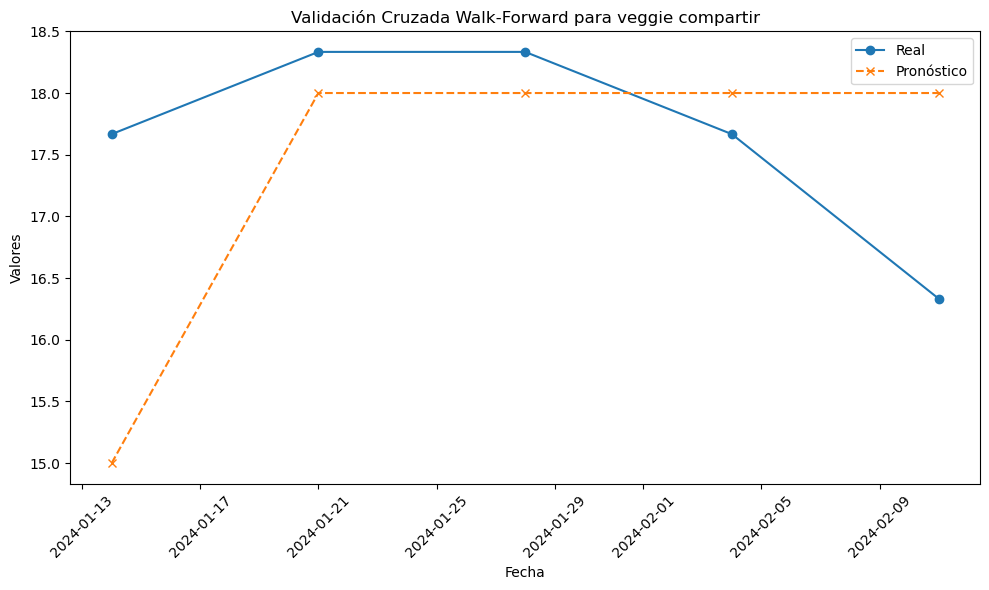

In [27]:
def walk_forward_validation(data, n_test):
    predictions = list()
    train, test = data[0:-n_test], data[-n_test:]
    history = [x for x in train]
    
    for i in range(len(test)):
        model = auto_arima(history, seasonal=True, m=4, stepwise=True, suppress_warnings=True, 
                           error_action="ignore", max_order=None, trace=False)
        yhat = model.predict(n_periods=1)[0]
        yhat_rounded = round(yhat)
        predictions.append(yhat_rounded)
        history.append(test[i])  # Agrega observaciones al entrenamiento para el próximo ciclo.
    
    error = np.sqrt(mean_squared_error(test, predictions))
    return error, test, predictions, model

resultados_rmse_wf= {}
modelos_entrenados = {}

# Ajuste de la cantidad de datos de prueba para la validación cruzada
n_test = 5  # Ejemplo: usar los últimos 5 puntos para la prueba

for producto in df_smoothed.columns:
    serie_temporal = df_smoothed[producto].dropna()
    
    # Aplicar validación cruzada "walk-forward"
    error, test, predictions, model = walk_forward_validation(serie_temporal, n_test)
    
    # Almacenar el modelo entrenado
    modelos_entrenados[producto] = model
    
    # Almacenar el error RMSE
    resultados_rmse_wf[producto] = error
    
    # Imprimir el RMSE para cada producto
    print(f"RMSE de validación cruzada para {producto}: {error:.3f}")
    
    # Fechas para el eje x
    fechas = serie_temporal.index[-n_test:]
    
    plt.figure(figsize=(10, 6))
    plt.plot(fechas, test, marker='o', label='Real')
    plt.plot(fechas, predictions, marker='x', linestyle='--', label='Pronóstico')
    plt.title(f'Validación Cruzada Walk-Forward para {producto}')
    plt.xlabel('Fecha')
    plt.ylabel('Valores')
    plt.legend()
    plt.xticks(rotation=45)  
    plt.tight_layout()
    plt.show()

Crearemos una funcion que permita seleccionar el producto y la fecha para ver su predicción, como los datos reales son hasta febrero, recomendamos hacer predicciones hasta mayo para mayor precesión, ya que al no tener actualización de datos las predicciones hasta más adelante se basan en predicciones donde no hay datos. 

In [28]:
def predict_for_specific_date(product, target_date, df_pivot, modelos_entrenados):
    if product not in df_pivot.columns:
        print("Producto no encontrado.")
        return None
    
    model = modelos_entrenados.get(product)
    
    if model is None:
        print("No se encontró un modelo entrenado para este producto.")
        return None

    target_date = pd.to_datetime(target_date)
    last_known_data = df_pivot[product].dropna()
    last_known_date = last_known_data.index[-1]

    if target_date <= last_known_date:
        print("La fecha objetivo debe ser posterior a la última fecha conocida en los datos.")
        return None

    periods_ahead = (target_date - last_known_date).days // 7

    # Asumiendo que los datos son semanales, ajustamos la serie temporal
    future_data = last_known_data.copy()
    for i in range(periods_ahead):
        # Entrenar el modelo con los datos actuales
        model = auto_arima(future_data, seasonal=True, m=4, stepwise=True, suppress_warnings=True,
                           error_action="ignore", max_order=None, trace=False)

        # Predecir el siguiente punto
        next_prediction = model.predict(n_periods=1)[0]

        # Actualizar los datos históricos con la nueva predicción
        new_index = future_data.index[-1] + pd.DateOffset(weeks=1)
        future_data = pd.concat([future_data, pd.Series([next_prediction], index=[new_index])])

    prediction_for_target_date = future_data.iloc[-1]
    return prediction_for_target_date

# Ajustar a fin de semana
def adjust_to_week_end(target_date, last_known_date):
    day_of_week = last_known_date.weekday()
    adjusted_date = target_date + pd.Timedelta(days=(6-day_of_week))
    return adjusted_date

producto_seleccionado = 'Hamburguesa Clasica'  # Asegúrate de que este producto esté en df_pivot.columns
fecha_objetivo = '2024-03-05'  # La fecha para la cual quieres la predicción

# Asegúrate de que df_pivot y modelos_entrenados están definidos y contienen los datos/modelos correctos
prediccion = predict_for_specific_date(producto_seleccionado, fecha_objetivo, df_pivot, modelos_entrenados)

print(f"La predicción ajustada al final de la semana para {producto_seleccionado} en {fecha_objetivo} es: {ceil(prediccion)}")


La predicción ajustada al final de la semana para Hamburguesa Clasica en 2024-03-05 es: 32


In [29]:
producto_seleccionado = 'Hamburguesa Clasica'  # Asegúrate de que este producto esté en df_pivot.columns
fecha_objetivo = '2024-07-05'  # La fecha para la cual quieres la predicción

# Asegúrate de que df_pivot y modelos_entrenados están definidos y contienen los datos/modelos correctos
prediccion = predict_for_specific_date(producto_seleccionado, fecha_objetivo, df_pivot, modelos_entrenados)

print(f"La predicción ajustada al final de la semana para {producto_seleccionado} en {fecha_objetivo} es: {ceil(prediccion)}")

La predicción ajustada al final de la semana para Hamburguesa Clasica en 2024-07-05 es: 33
